In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from mlxtend.regressor import StackingCVRegressor
#from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from scipy.stats import probplot
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from scipy.special import boxcox1p, inv_boxcox1p
from scipy.stats import boxcox_normmax
import math
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
#sample_submission = pd.read_csv('/kaggle/input/bike-sharing-demand/sampleSubmission.csv')

data = pd.concat([df_train, df_test], axis = 0)
data.reset_index(drop = True, inplace = True)

data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


In [2]:
data['hour'] = data['datetime'].str.split(' ', expand = True)[1].str.split(':', expand = True)[0].astype(int).astype('category')
df_train['hour'] = df_train['datetime'].str.split(' ', expand = True)[1].str.split(':', expand = True)[0].astype(int).astype('category')
df_test['hour'] = df_test['datetime'].str.split(' ', expand = True)[1].str.split(':', expand = True)[0].astype(int).astype('category')

data['month'] = data['datetime'].str.split(' ', expand = True)[0].str.split('-', expand = True)[1].astype(int).astype('category')
df_train['month'] = df_train['datetime'].str.split(' ', expand = True)[0].str.split('-', expand = True)[1].astype(int).astype('category')
df_test['month'] = df_test['datetime'].str.split(' ', expand = True)[0].str.split('-', expand = True)[1].astype(int).astype('category')

data['day'] = data['datetime'].str.split(' ', expand = True)[0].str.split('-', expand = True)[2].astype(int).astype('category')
df_train['day'] = df_train['datetime'].str.split(' ', expand = True)[0].str.split('-', expand = True)[2].astype(int).astype('category')
df_test['day'] = df_test['datetime'].str.split(' ', expand = True)[0].str.split('-', expand = True)[2].astype(int).astype('category')

data['year'] = data['datetime'].str.split(' ', expand = True)[0].str.split('-', expand = True)[0].astype(int).map({2011: 0, 2012:1}).astype('category')
df_train['year'] = df_train['datetime'].str.split(' ', expand = True)[0].str.split('-', expand = True)[0].astype(int).map({2011: 0, 2012:1}).astype('category')
df_test['year'] = df_test['datetime'].str.split(' ', expand = True)[0].str.split('-', expand = True)[0].astype(int).map({2011: 0, 2012:1}).astype('category')

data['season'] = data['season'].astype('category')
data['holiday'] = data['holiday'].astype('category')
data['workingday'] = data['workingday'].astype('category')
data['weather'] = data['weather'].astype('category')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   datetime    17379 non-null  object  
 1   season      17379 non-null  category
 2   holiday     17379 non-null  category
 3   workingday  17379 non-null  category
 4   weather     17379 non-null  category
 5   temp        17379 non-null  float64 
 6   atemp       17379 non-null  float64 
 7   humidity    17379 non-null  int64   
 8   windspeed   17379 non-null  float64 
 9   casual      10886 non-null  float64 
 10  registered  10886 non-null  float64 
 11  count       10886 non-null  float64 
 12  hour        17379 non-null  category
 13  month       17379 non-null  category
 14  day         17379 non-null  category
 15  year        17379 non-null  category
dtypes: category(8), float64(6), int64(1), object(1)
memory usage: 1.2+ MB


In [4]:
num_feature = data.select_dtypes(include = ['int64', 'float64']).columns.to_list()
cat_feature = data.select_dtypes(include = 'category').columns.to_list()

num_feature, cat_feature

(['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
 ['season',
  'holiday',
  'workingday',
  'weather',
  'hour',
  'month',
  'day',
  'year'])

Skew of Count in training data:  1.2420662117180776
Kurtosis of Count in training data:  1.3000929518398334
Mean of Count in training data:  191.57413191254824
Median of Count in training data:  145.0


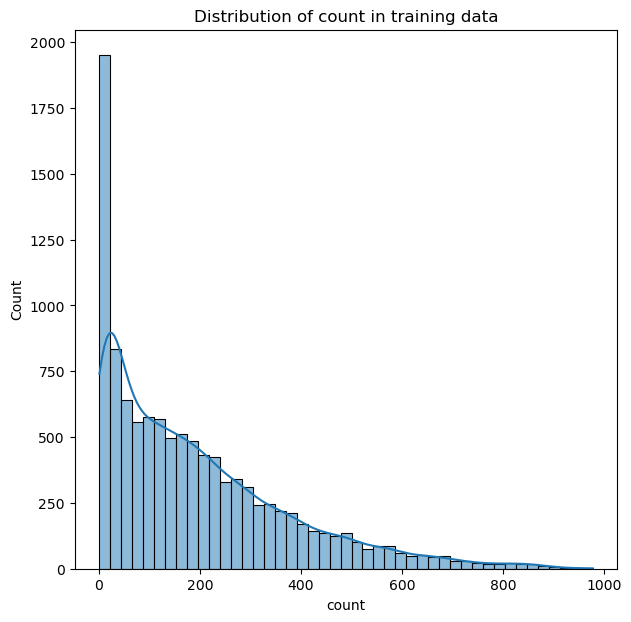

In [5]:
print("Skew of Count in training data: ", df_train['count'].skew())
print("Kurtosis of Count in training data: " , df_train['count'].kurt())
print("Mean of Count in training data: ", df_train['count'].mean())
print("Median of Count in training data: ", df_train['count'].median())

fig, ax = plt.subplots(nrows = 1, figsize = (7, 7))
plt.subplots_adjust(hspace = 0.5)

sns.histplot(df_train['count'], kde = True, ax = ax)

ax.set_title('Distribution of count in training data');

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

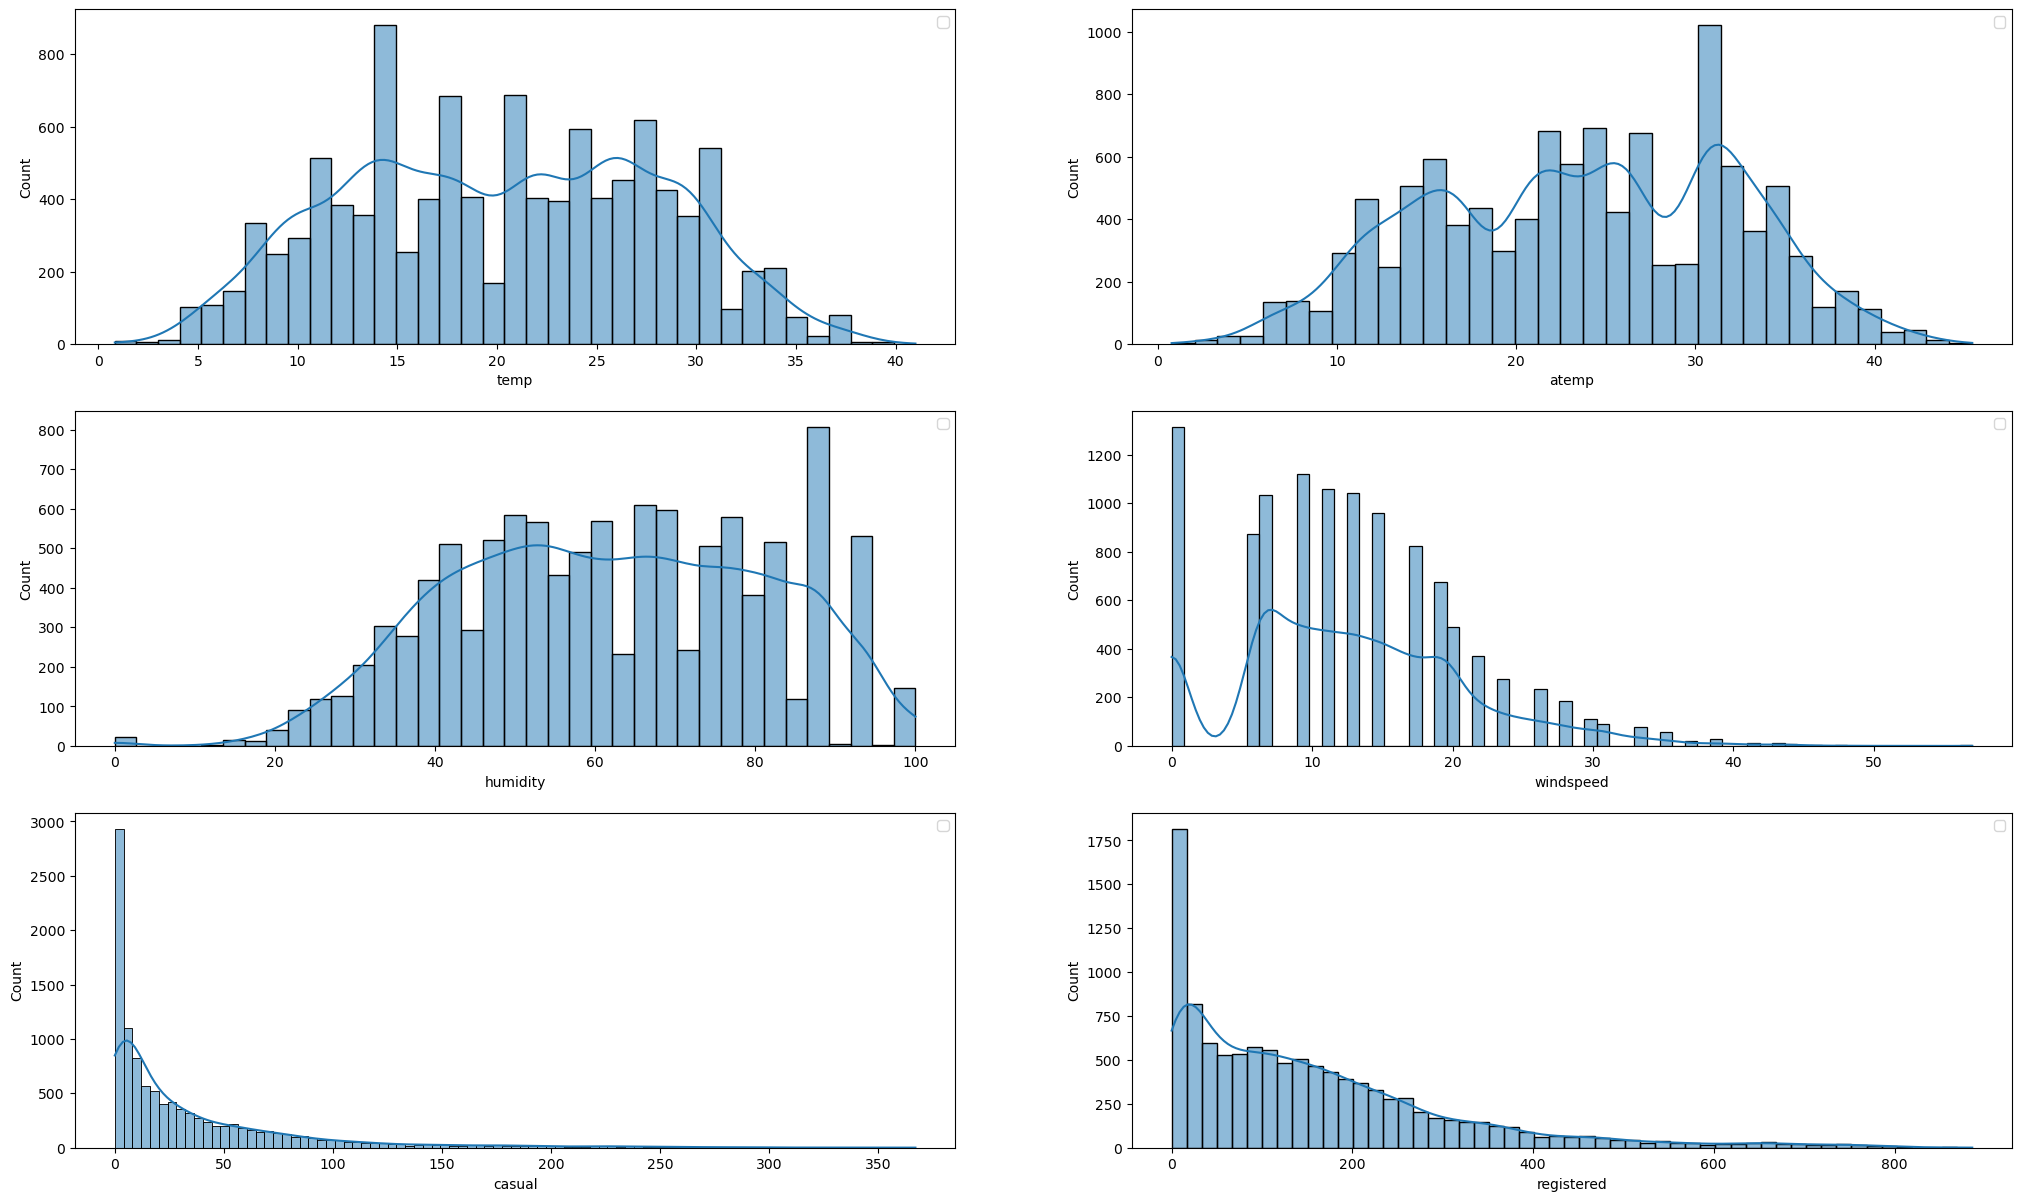

In [6]:
fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (25, 20))

for i, feature in enumerate(num_feature, 1):
    plt.subplot(4, 2, i)
    
    sns.histplot(df_train[feature], kde = True)
    
    plt.legend(loc = 'best')
    

fig.delaxes(ax[3][1])
fig.delaxes(ax[3][0])

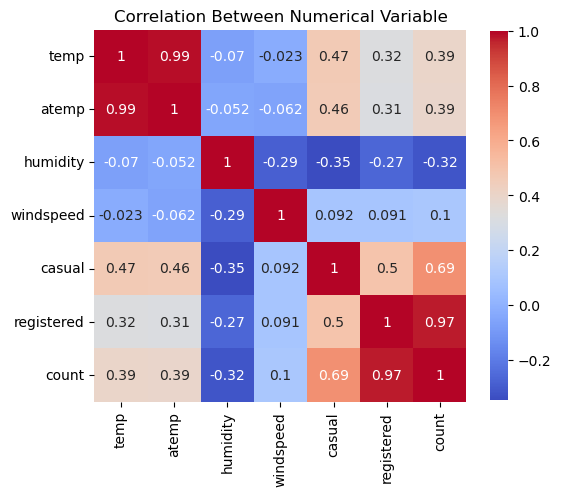

In [7]:
corr_map = data[num_feature].corr()

fig, ax = plt.subplots(figsize = (6, 6))

sns.heatmap(corr_map, square = True, annot = True, cmap = 'coolwarm', ax = ax, cbar_kws = {'shrink': 0.8})
ax.set_title('Correlation Between Numerical Variable');

In [8]:
from sklearn.feature_selection import f_regression

f_stats, p_score = f_regression(df_train[cat_feature], df_train['count'])

score_chart = pd.DataFrame({'Feature': cat_feature, 'f_statistics': f_stats.round(2), 'P_Value': p_score.round(2)})

score_chart

,Feature,f_statistics,P_Value
0,season,298.72,0.00
1,holiday,0.32,0.57
2,workingday,1.46,0.23
3,weather,183.19,0.00
4,hour,2080.57,0.00
5,month,311.72,0.00
6,day,4.28,0.04
7,year,791.73,0.00


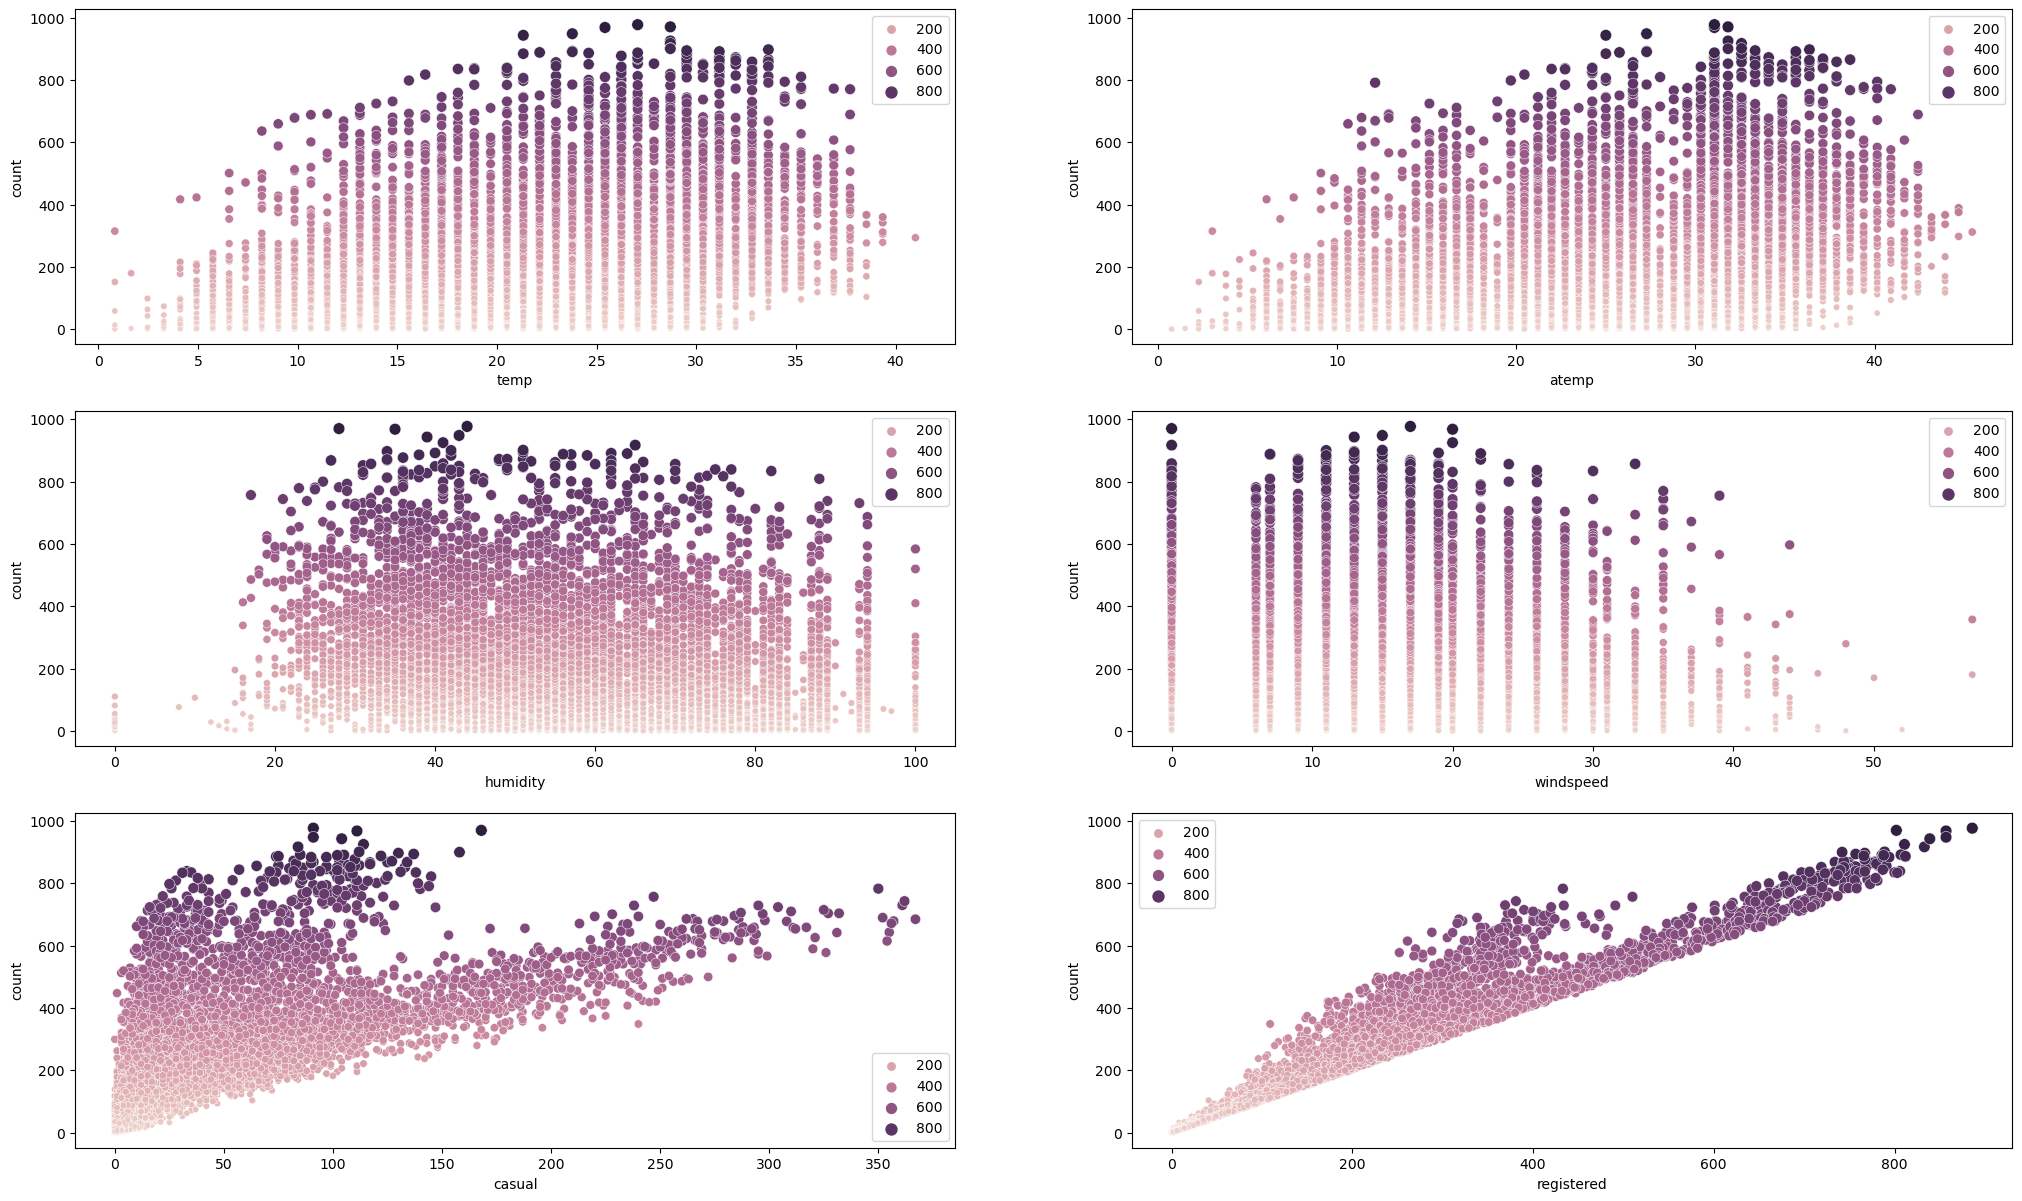

In [9]:
fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (25, 20))

for i, feature in enumerate(num_feature, 1):
    plt.subplot(4, 2, i)
    
    sns.scatterplot(df_train, x = feature, y = 'count', hue = 'count', size = 'count')
    
    plt.legend(loc = 'best')
    

fig.delaxes(ax[3][1])
fig.delaxes(ax[3][0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

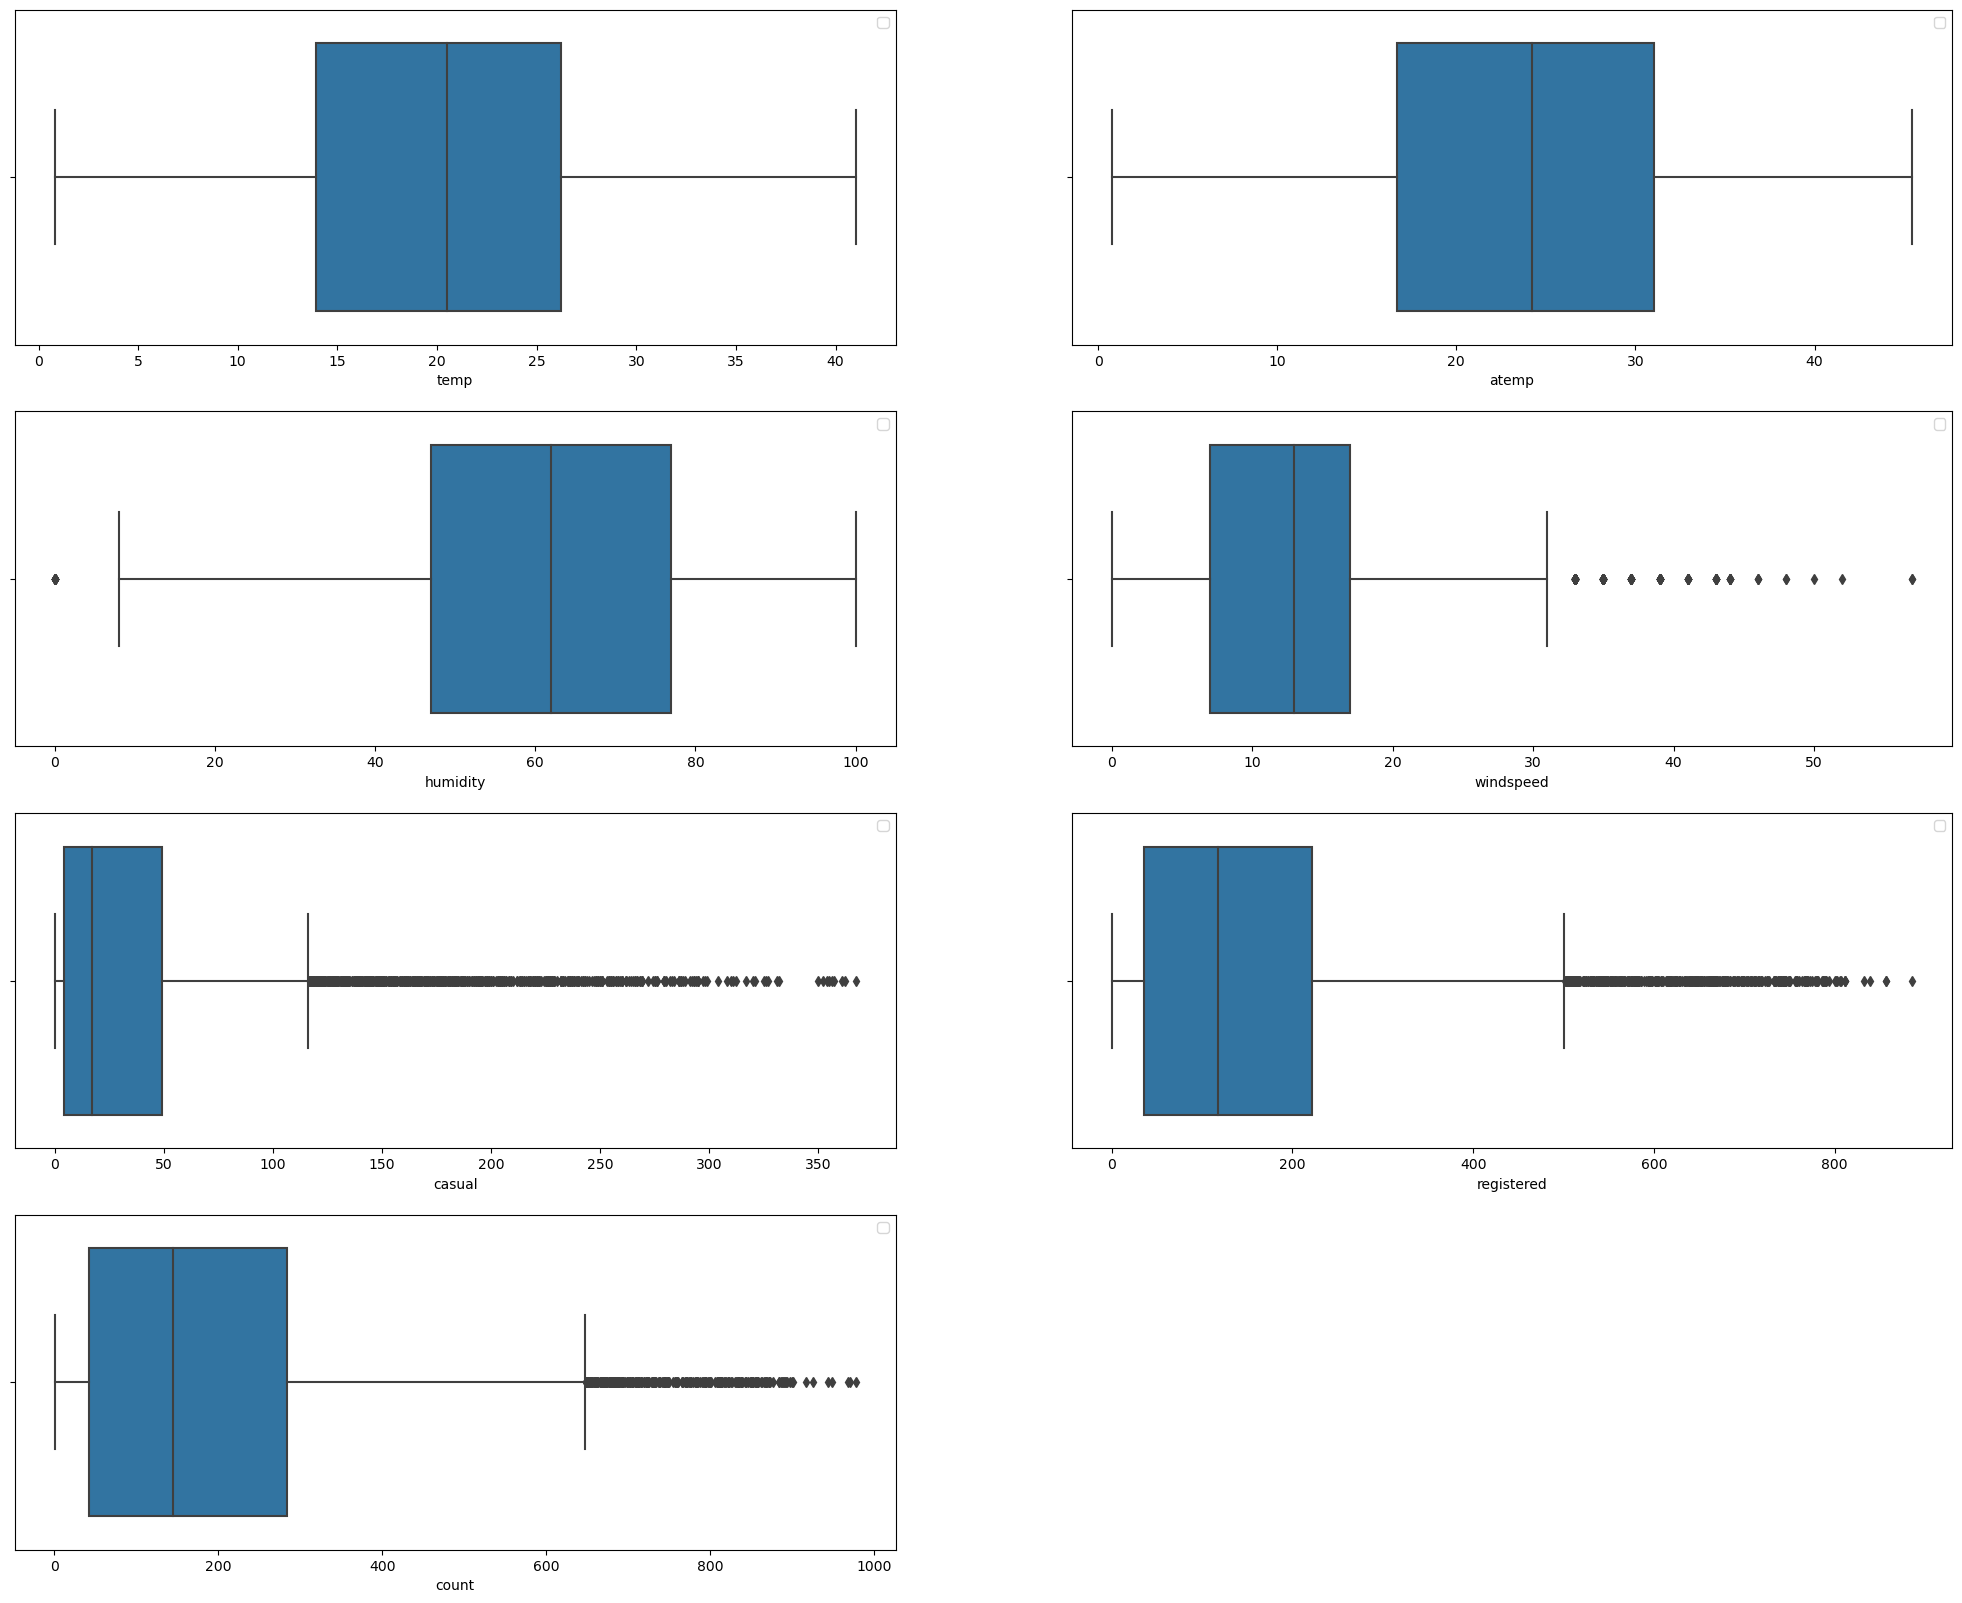

In [10]:
fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (25, 20))

for i, feature in enumerate(num_feature, 1):
    plt.subplot(4, 2, i)
    
    sns.boxplot(df_train, x = feature)
    
    plt.legend(loc = 'best')
    

fig.delaxes(ax[3][1])
# fig.delaxes(ax[3][0])

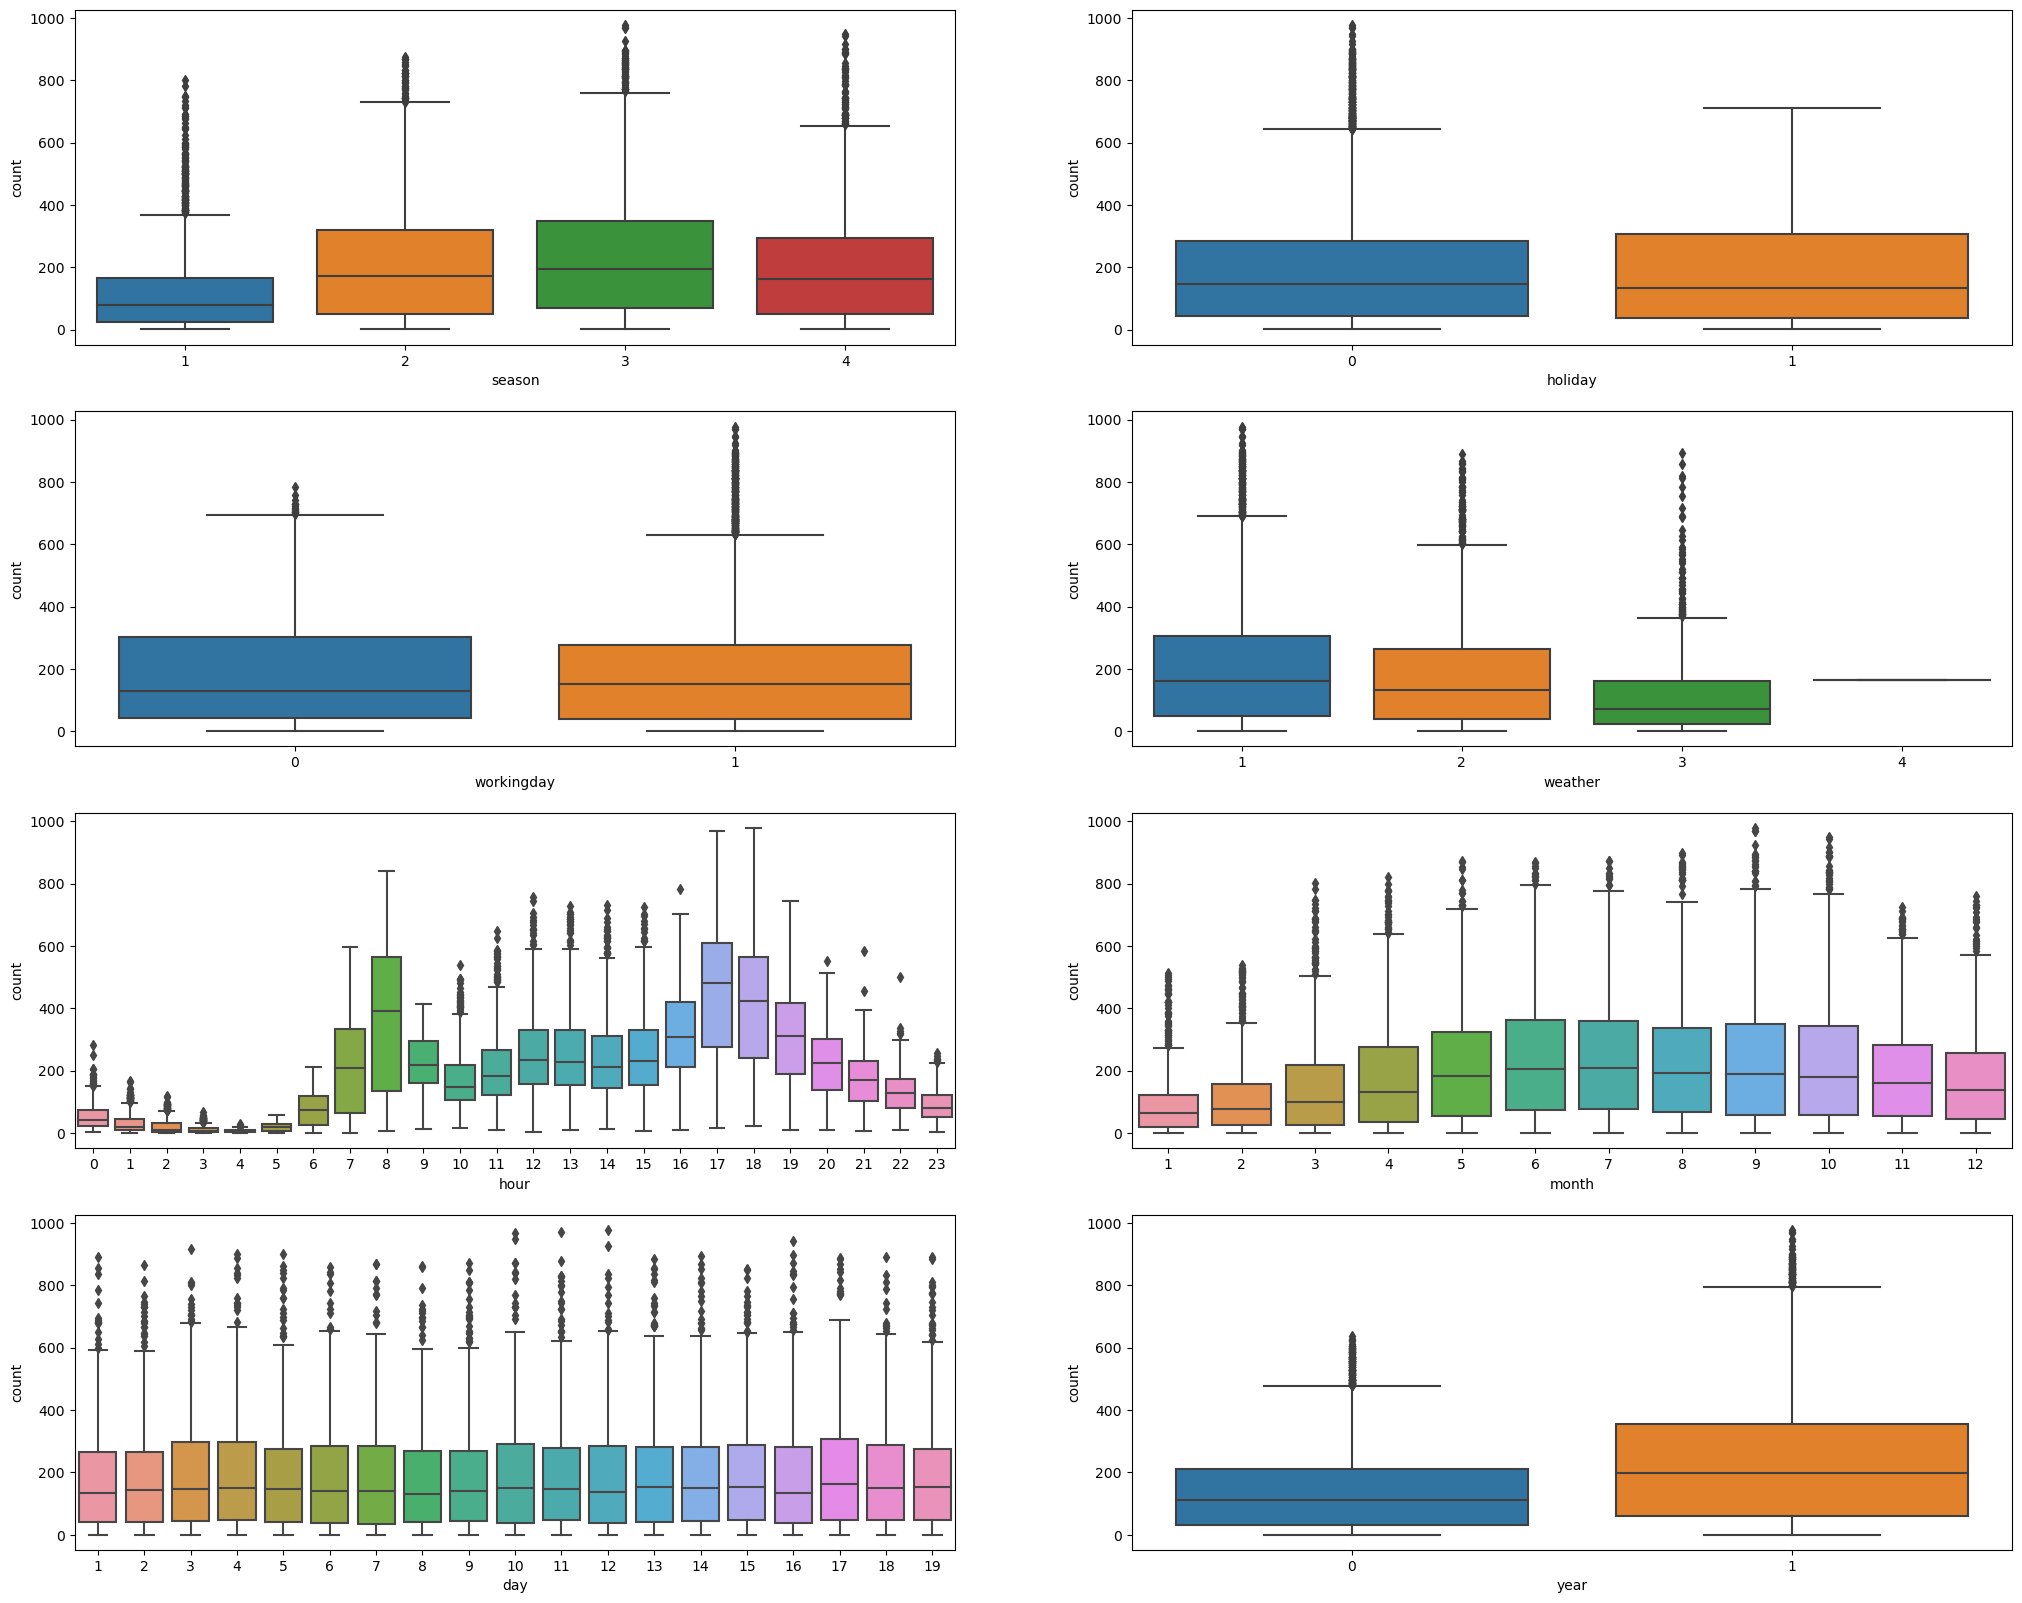

In [11]:
fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (25, 20))

for i, feature in enumerate(cat_feature, 1):
    plt.subplot(4, 2, i)
    
    sns.boxplot(df_train, x = feature, y = 'count', orient = 'v')
    

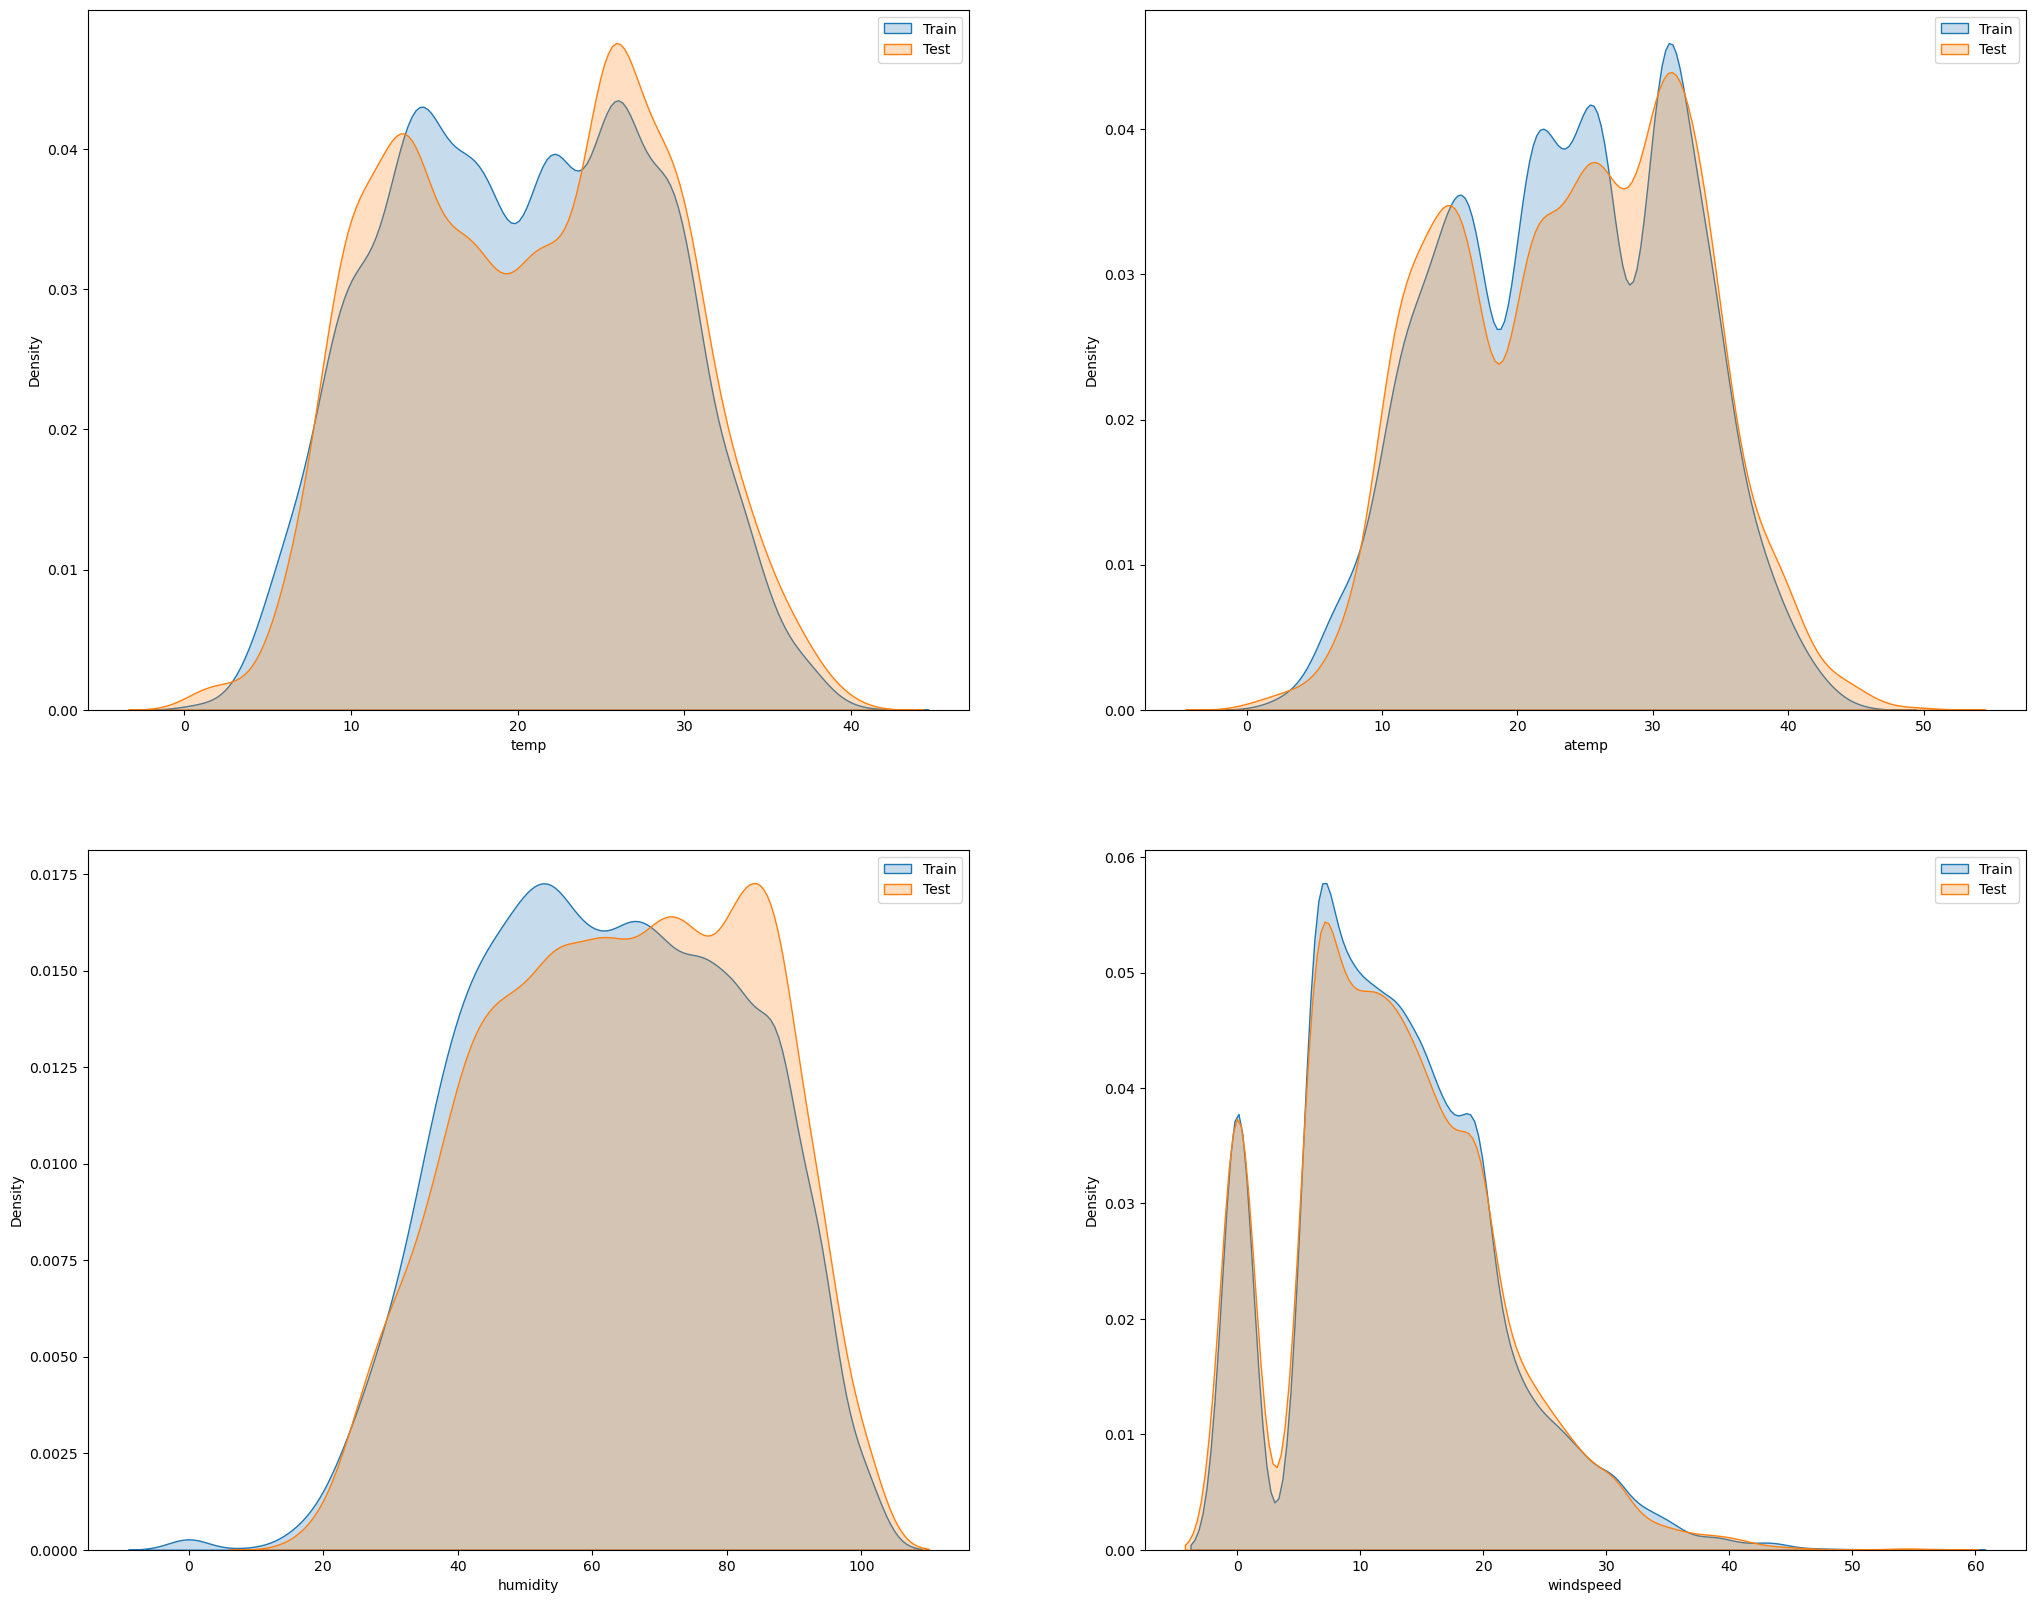

In [12]:
num_feature_ex = ['temp', 'atemp', 'humidity', 'windspeed']

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (25, 20))

for i, feature in enumerate(num_feature_ex, 1):
    plt.subplot(2, 2, i)
    
    sns.kdeplot(data.loc[data['count'].notnull()], x = feature, shade = True, label = 'Train')
    sns.kdeplot(data.loc[data['count'].isnull()], x = feature, shade = True, label = 'Test')
    
    plt.legend(loc = 1)
    

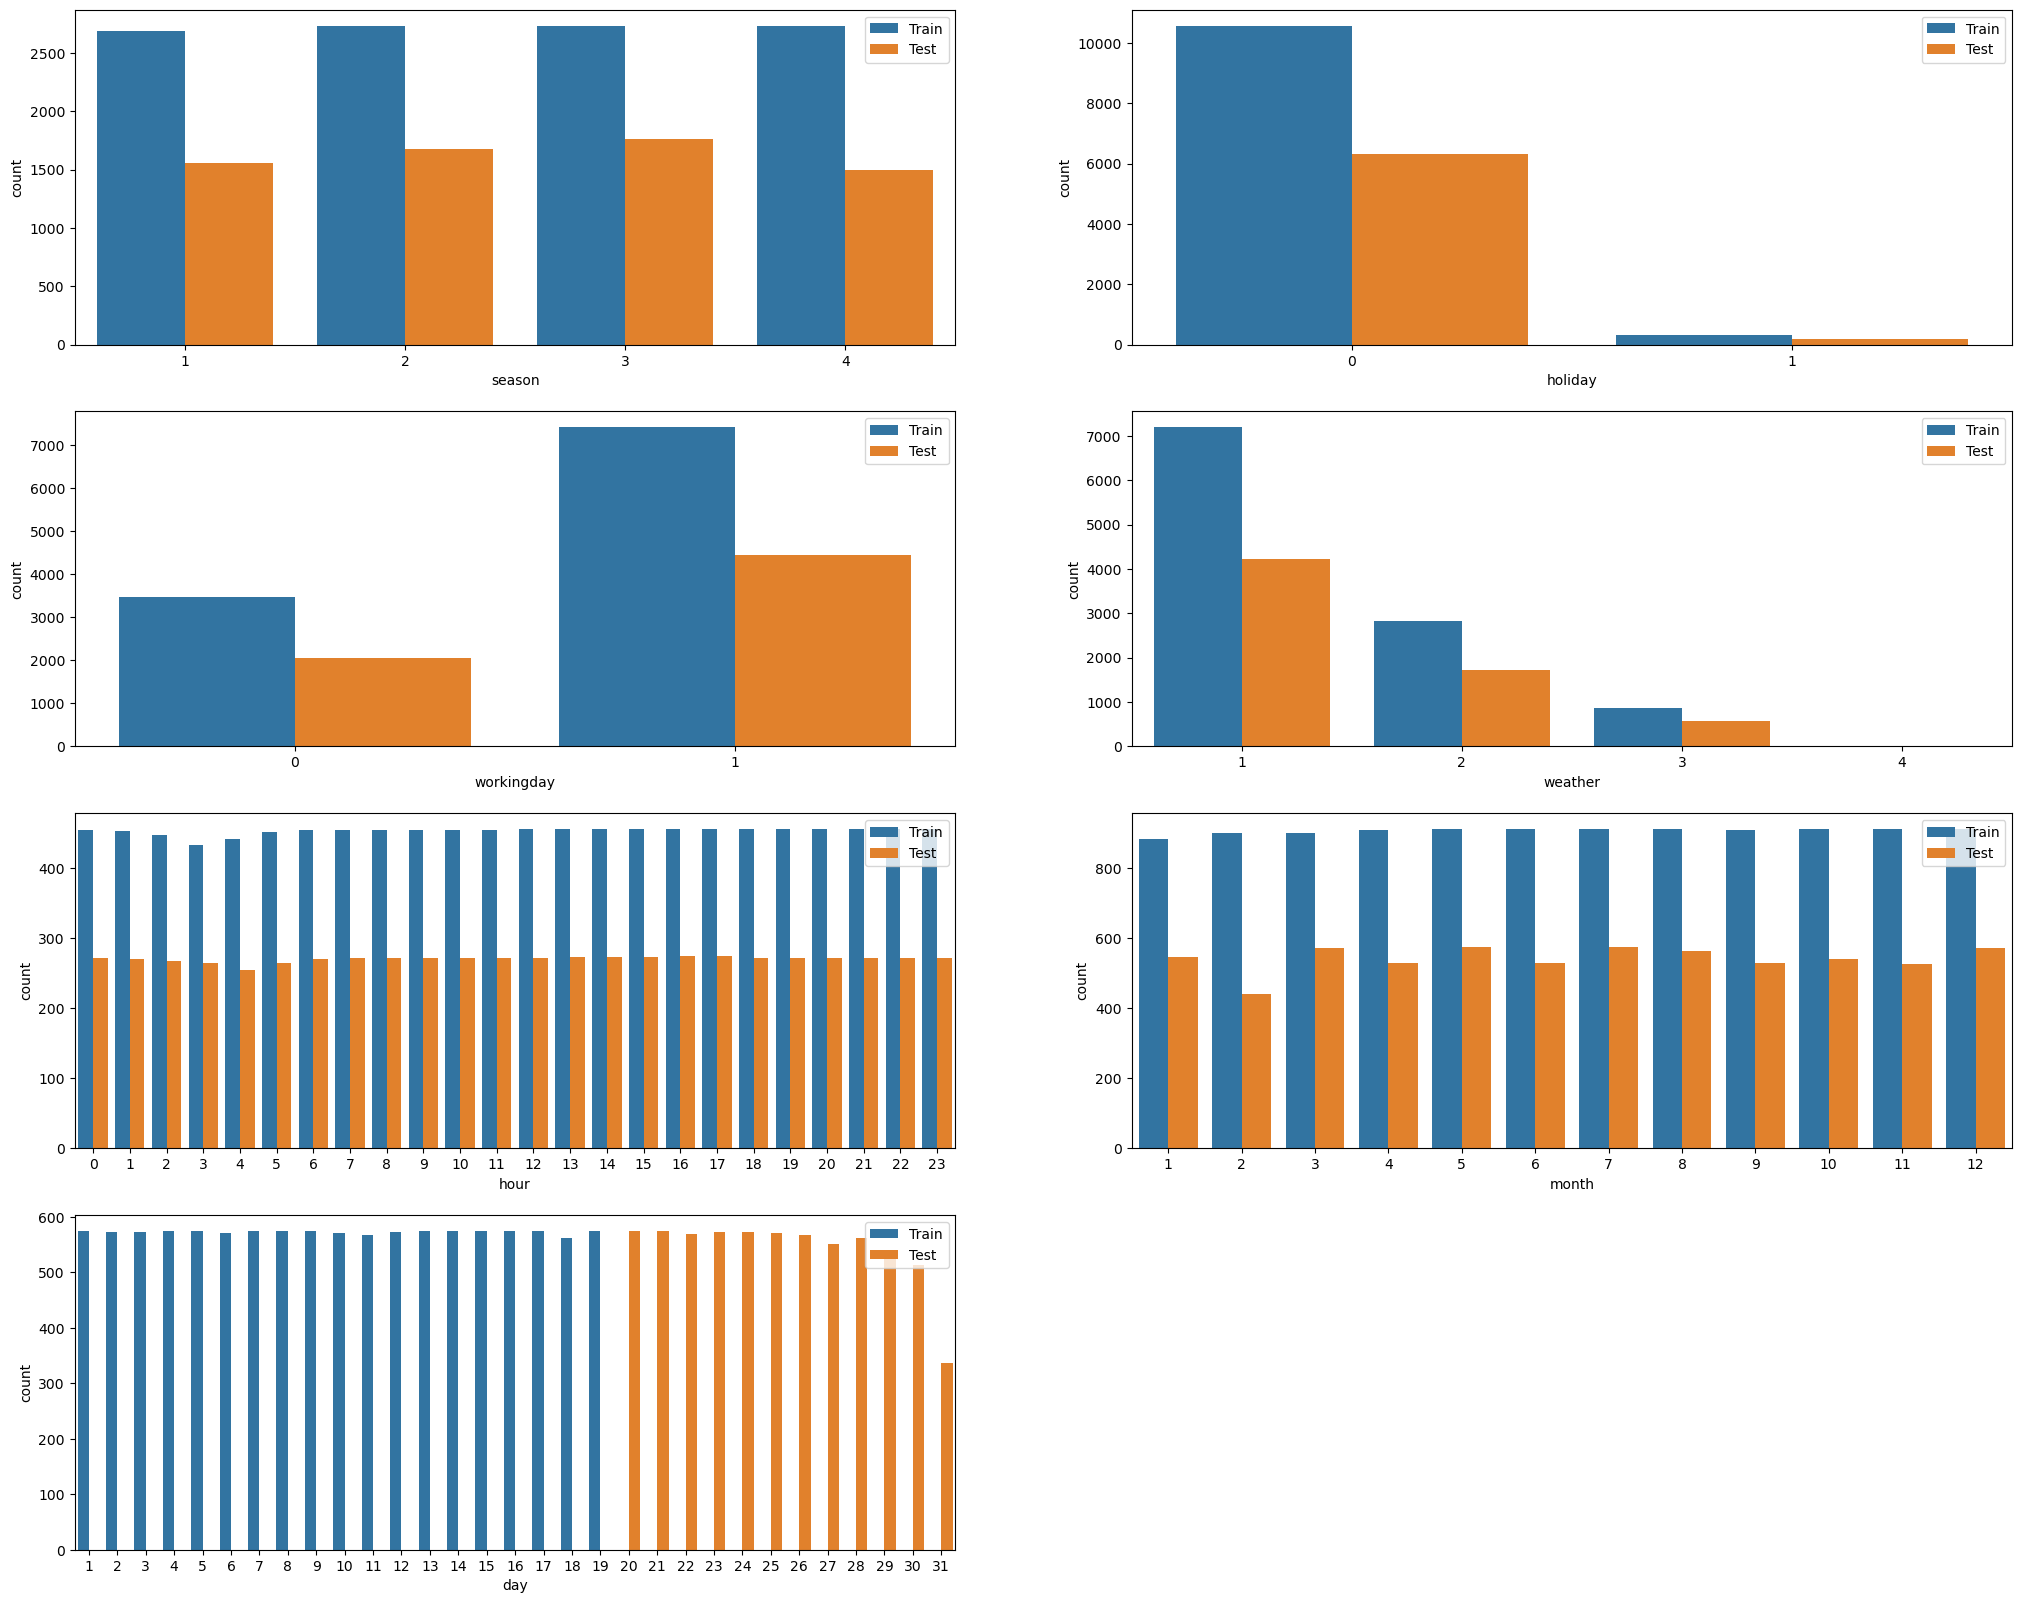

In [13]:
data['Train'] = 'Train'
data.loc[data['count'].isnull(), 'Train'] = 'Test'

fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (25, 20))

for i, feature in enumerate(cat_feature, 1):
    plt.subplot(4, 2, i)
    
    sns.countplot(data, x = feature, hue = 'Train')
    
    plt.legend(loc = 1)
    

fig.delaxes(ax[3][1])

data.drop(['Train'], axis = 1, inplace = True)

In [14]:
def OrdEncode(feature, target):
    ke = data.groupby(feature)[target].mean().sort_values().to_dict().keys()
    
    hour_map = dict({})
    cnt = 1
    
    for key in ke:
        hour_map[key] = cnt
        cnt+=1
    
    return hour_map

In [15]:
data.loc[data['humidity'] == 0, 'humidity'] = np.nan

df = data.copy()

#Ordinal Encoding
df['hour'] = df['hour'].map(OrdEncode('hour', 'humidity'))

#One Hot Encoding
encode = pd.get_dummies(df[['month', 'season']].astype('str'), dtype = int, drop_first = True)
df = pd.concat([df, encode], axis = 1)

df.drop(['month', 'weather', 'season', 'holiday', 'workingday', 'day', 'datetime', 'casual', 'registered', 'temp', 'atemp', 'windspeed', 'year'], axis = 1, inplace = True)

#Train the imputer
cat_imputer = make_pipeline(StandardScaler(), CatBoostRegressor(depth = 10, iterations = 200, learning_rate =  0.1, logging_level="Silent"))

x_imputer = df.loc[df['humidity'].notnull()].drop('humidity', axis = 1)
y_imputer = df.loc[df['humidity'].notnull(), 'humidity']

test_imputer = df.loc[df['humidity'].isnull()].drop('humidity', axis = 1)

cat_imputer.fit(x_imputer, y_imputer)

#Fill the missing value
data.loc[data['humidity'].isnull(), 'humidity'] = cat_imputer.predict(test_imputer)

In [16]:
#Ordinal Encoding
data['hour'] = data['hour'].map(OrdEncode('hour', 'count'))

#One Hot Encoding
encode = pd.get_dummies(data[['month', 'weather', 'season', 'workingday', 'day']].astype('str'), dtype = int, drop_first = True)
data = pd.concat([data, encode], axis = 1)

In [17]:
data.drop(['month', 'weather', 'season', 'holiday', 'day', 'workingday', 'datetime', 'casual', 'registered'], axis = 1, inplace = True)
data.head()

,temp,atemp,humidity,windspeed,count,hour,year,month_10,month_11,month_12,...,day_29,day_3,day_30,day_31,day_4,day_5,day_6,day_7,day_8,day_9
0,9.84,14.395,81.0,0.0,16.0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9.02,13.635,80.0,0.0,40.0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.02,13.635,80.0,0.0,32.0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9.84,14.395,75.0,0.0,13.0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9.84,14.395,75.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
x = data.loc[data['count'].notnull()].drop('count', axis = 1)

test_data = data.loc[data['count'].isnull()].drop('count', axis = 1)

y = data.loc[data['count'].notnull(), 'count']

In [19]:
def cross_val(model, x, y):
    
    KF = KFold(n_splits = 5, shuffle = True, random_state = 42)
    fold = 0
    scores = []
    
    for train_index, test_index in KF.split(x, y):
        
        fold += 1
        
        x_train = x[train_index]
        y_train = y[train_index]
        
        x_test = x[test_index]
        y_test = y[test_index]
                
        #box cox transformation to the target variable
        lamb = boxcox_normmax(y_train)
        y_train = boxcox1p(y_train, lamb)
        
        model.fit(x_train, y_train)
        
        #inverse box cox transformation to the predicted value
        y_pred = np.clip(inv_boxcox1p(model.predict(x_test), lamb).round(0).astype(int), a_min = 0, a_max = np.inf)

        scores.append(np.sqrt(mean_squared_log_error(y_pred, y_test)))
        
        print(f"RMSLE score for {fold} fold: {np.sqrt(mean_squared_log_error(y_pred, y_test))}")
        
    print(f"Final Score: {np.mean(scores)}")

In [20]:
#CatBoost
cat_model = make_pipeline(StandardScaler(), CatBoostRegressor(depth = 10, iterations = 200, learning_rate =  0.1, logging_level="Silent"))

cross_val(cat_model, x.values, y.values)

RMSLE score for 1 fold: 0.3296092831911513
RMSLE score for 2 fold: 0.3219296607165896
RMSLE score for 3 fold: 0.32459585870915236
RMSLE score for 4 fold: 0.3150186899812414
RMSLE score for 5 fold: 0.33196002883872855
Final Score: 0.32462270428737267


In [21]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [22]:
#LGBM Regressor
from lightgbm import LGBMRegressor
lgbm_model = make_pipeline(StandardScaler(), LGBMRegressor(objective = 'regression', bagging_fraction = 0.75, bagging_freq = 5, bagging_seed = 42, feature_fraction = 0.6, feature_fraction_seed = 42, learning_rate = 0.1, max_bin = 200, n_estimators = 3000, num_leaves = 14, verbose = -1))

cross_val(lgbm_model, x.values, y.values)

RMSLE score for 1 fold: 0.3249614234389254
RMSLE score for 2 fold: 0.3295484591113406
RMSLE score for 3 fold: 0.3394153662185678
RMSLE score for 4 fold: 0.3167267296236617
RMSLE score for 5 fold: 0.3352126759812429
Final Score: 0.32917293087474764


In [23]:
#XGBoost Regressor
xgb_model = XGBRegressor(objective = 'reg:squaredlogerror', colsample_bytree = 0.7, gamma = 0.001, learning_rate = 0.1, max_depth = 8, n_estimators = 2000, nthread = -1, reg_alpha = 0.01, seed = 42, subsample = 0.95, enable_categorical = True)

cross_val(xgb_model, x.values, y.values)

RMSLE score for 1 fold: 0.3345665490614432
RMSLE score for 2 fold: 0.33422009312767204
RMSLE score for 3 fold: 0.33866439291429423
RMSLE score for 4 fold: 0.3242979015829358
RMSLE score for 5 fold: 0.3345100729752822
Final Score: 0.33325180193232545


In [24]:
def cross_val_blending(cat, lgbm, xgb, x, y, p1, p2, p3):
    
    KF = KFold(n_splits = 5, shuffle = True, random_state = 42)
    fold = 0
    scores = []
    
    for train_index, test_index in KF.split(x, y):
        
        fold += 1
        
        x_train = x[train_index]
        y_train = y[train_index]
        
        x_test = x[test_index]
        y_test = y[test_index] 
        
       
        #box cox transformation to the target variable
        lamb = boxcox_normmax(y_train)
        y_train = boxcox1p(y_train, lamb)
        
        cat.fit(x_train, y_train)
        lgbm.fit(x_train, y_train)
        xgb.fit(x_train, y_train)
        
        #inverse box cox transformation to the predicted value
        cat_pred = inv_boxcox1p(cat_model.predict(x_test), lamb)
        lgbm_pred = inv_boxcox1p(lgbm_model.predict(x_test), lamb)
        xgb_pred = inv_boxcox1p(xgb_model.predict(x_test), lamb)
        
        y_final = (p1 * cat_pred) + (p2 * lgbm_pred) + ((p3) * xgb_pred)
        y_final = np.clip(y_final.round(0).astype(int), a_min = 0, a_max = np.inf)

        
        
        scores.append(np.sqrt(mean_squared_log_error(y_final, y_test)))
        
        print(f"RMSLE score for {fold} fold: {np.sqrt(mean_squared_log_error(y_final, y_test))}")
        
    print(f"Final Score: {np.mean(scores)}")

In [25]:
cat_model = make_pipeline(StandardScaler(), CatBoostRegressor(depth = 10, iterations = 200, learning_rate =  0.1, logging_level="Silent"))
lgbm_model = make_pipeline(StandardScaler(), LGBMRegressor(objective = 'regression', bagging_fraction = 0.75, bagging_freq = 5, bagging_seed = 42, feature_fraction = 0.6, feature_fraction_seed = 42, learning_rate = 0.1, max_bin = 200, n_estimators = 3000, num_leaves = 14, verbose = -1))
xgb_model = XGBRegressor(objective = 'reg:squaredlogerror', colsample_bytree = 0.7, gamma = 0.001, learning_rate = 0.1, max_depth = 8, n_estimators = 2000, nthread = -1, reg_alpha = 0.01, seed = 42, subsample = 0.95, enable_categorical = True)

cross_val_blending(cat_model, lgbm_model, xgb_model, x.values, y.values, 0.6, 0, 0.4)

RMSLE score for 1 fold: 0.32069644121261437
RMSLE score for 2 fold: 0.31393429449719323
RMSLE score for 3 fold: 0.3193011142704882
RMSLE score for 4 fold: 0.30860058310783156
RMSLE score for 5 fold: 0.3222392742990089
Final Score: 0.3169543414774273


In [26]:
#import pandas as pd

#sample_submission = pd.read_csv('/kaggle/input/bike-sharing-demand/sampleSubmission.csv')


cat_model = make_pipeline(StandardScaler(), CatBoostRegressor(depth = 10, iterations = 200, learning_rate =  0.1, logging_level="Silent"))
lgbm_model = make_pipeline(StandardScaler(), LGBMRegressor(objective = 'regression', bagging_fraction = 0.75, bagging_freq = 5, bagging_seed = 42, feature_fraction = 0.6, feature_fraction_seed = 42, learning_rate = 0.1, max_bin = 200, n_estimators = 3000, num_leaves = 14, verbose = -1))
xgb_model = XGBRegressor(objective = 'reg:squaredlogerror', colsample_bytree = 0.7, gamma = 0.001, learning_rate = 0.1, max_depth = 8, n_estimators = 2000, nthread = -1, reg_alpha = 0.01, seed = 42, subsample = 0.95, enable_categorical = True)

lamb = boxcox_normmax(y)
y = boxcox1p(y, lamb)

cat_model.fit(x, y)
lgbm_model.fit(x, y)
xgb_model.fit(x, y)

cat_pred = inv_boxcox1p(cat_model.predict(test_data), lamb)
lgbm_pred = inv_boxcox1p(lgbm_model.predict(test_data), lamb)
xgb_pred = inv_boxcox1p(xgb_model.predict(test_data), lamb)

y_final = (0.6 * cat_pred) + (0 * lgbm_pred) + (0.4 * xgb_pred)
y_final = np.clip(y_final.round(0).astype(int), a_min = 0, a_max = np.inf)

#submit = pd.DataFrame({'datetime': sample_submission['datetime'], 'count': y_final})
#submit.to_csv('Submission.csv', index = False)

# prediction for 2013 using #CatBoost,#LGBM Regressor,#XGBoost Regressor models

In [27]:
# Load train and test data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Convert datetime column to datetime data type
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])

# Extract relevant features
train_df['year'] = train_df['datetime'].dt.year
train_df['month'] = train_df['datetime'].dt.month
train_df['day'] = train_df['datetime'].dt.day
train_df['hour'] = train_df['datetime'].dt.hour

test_df['year'] = test_df['datetime'].dt.year
test_df['month'] = test_df['datetime'].dt.month
test_df['day'] = test_df['datetime'].dt.day
test_df['hour'] = test_df['datetime'].dt.hour

# Drop the original datetime column
train_df.drop('datetime', axis=1, inplace=True)
test_df.drop('datetime', axis=1, inplace=True)

# Prepare features and target variable
X_train = train_df.drop('count', axis=1)
y_train = train_df['count']

In [28]:
# Initialize models
cat_model = CatBoostRegressor()
lgbm_model = LGBMRegressor()
xgb_model = XGBRegressor()

In [29]:
# Train models
cat_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

Learning rate set to 0.059704
0:	learn: 171.2404226	total: 7.11ms	remaining: 7.11s
1:	learn: 162.0903997	total: 12.8ms	remaining: 6.4s
2:	learn: 153.6313542	total: 17.7ms	remaining: 5.88s
3:	learn: 145.0903721	total: 22.8ms	remaining: 5.68s
4:	learn: 137.3726218	total: 26.4ms	remaining: 5.25s
5:	learn: 130.0133332	total: 31.3ms	remaining: 5.19s
6:	learn: 123.0959607	total: 36.3ms	remaining: 5.15s
7:	learn: 116.5544947	total: 40.8ms	remaining: 5.05s
8:	learn: 110.5545927	total: 45ms	remaining: 4.95s
9:	learn: 104.6185960	total: 49.3ms	remaining: 4.88s
10:	learn: 99.0357904	total: 53.2ms	remaining: 4.78s
11:	learn: 93.7383468	total: 58.2ms	remaining: 4.79s
12:	learn: 88.9647402	total: 63.2ms	remaining: 4.8s
13:	learn: 84.3355652	total: 67.5ms	remaining: 4.76s
14:	learn: 80.0375988	total: 71.8ms	remaining: 4.71s
15:	learn: 75.8618453	total: 76.6ms	remaining: 4.71s
16:	learn: 71.8452487	total: 80.9ms	remaining: 4.68s
17:	learn: 67.9850894	total: 85.7ms	remaining: 4.68s
18:	learn: 64.465592

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [30]:
# Step 3: Generate synthetic test data for 2013
# For demonstration, let's create synthetic data with similar features as training data
test_2013_data = pd.DataFrame({
    'datetime': pd.date_range(start='2013-01-01', end='2013-12-31', freq='H'),  # Assuming hourly data
    'season': np.random.randint(1, 5, size=len(pd.date_range(start='2013-01-01', end='2013-12-31', freq='H'))),
    'holiday': np.random.choice([0, 1], size=len(pd.date_range(start='2013-01-01', end='2013-12-31', freq='H'))),
    'workingday': np.random.choice([0, 1], size=len(pd.date_range(start='2013-01-01', end='2013-12-31', freq='H'))),
    'weather': np.random.randint(1, 5, size=len(pd.date_range(start='2013-01-01', end='2013-12-31', freq='H'))),
    'temp': np.random.uniform(0, 40, size=len(pd.date_range(start='2013-01-01', end='2013-12-31', freq='H'))),
    'humidity': np.random.randint(0, 100, size=len(pd.date_range(start='2013-01-01', end='2013-12-31', freq='H'))),
    'windspeed': np.random.uniform(0, 30, size=len(pd.date_range(start='2013-01-01', end='2013-12-31', freq='H')))
})

In [31]:
# Step 4: Make predictions for 2013 using the trained models
# Ensure that test_2013_data contains the same columns as X_train
test_2013_data = test_2013_data.reindex(columns=X_train.columns, fill_value=0)

cat_pred_2013 = cat_model.predict(test_2013_data)
lgbm_pred_2013 = lgbm_model.predict(test_2013_data)
xgb_pred_2013 = xgb_model.predict(test_2013_data)


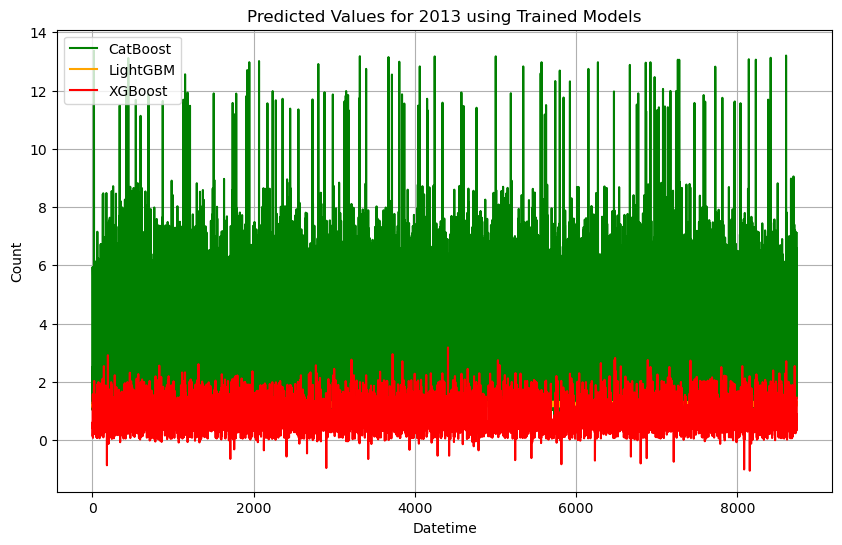

In [32]:
import matplotlib.pyplot as plt

# Assuming test_2013_data is the DataFrame containing the features for 2013

# Plot predicted values for each model
plt.figure(figsize=(10, 6))
plt.plot(test_2013_data.index, cat_pred_2013, label='CatBoost', color='green')
plt.plot(test_2013_data.index, lgbm_pred_2013, label='LightGBM', color='orange')
plt.plot(test_2013_data.index, xgb_pred_2013, label='XGBoost', color='red')

plt.xlabel('Datetime')
plt.ylabel('Count')
plt.title('Predicted Values for 2013 using Trained Models')
plt.legend()
plt.grid(True)
plt.show()


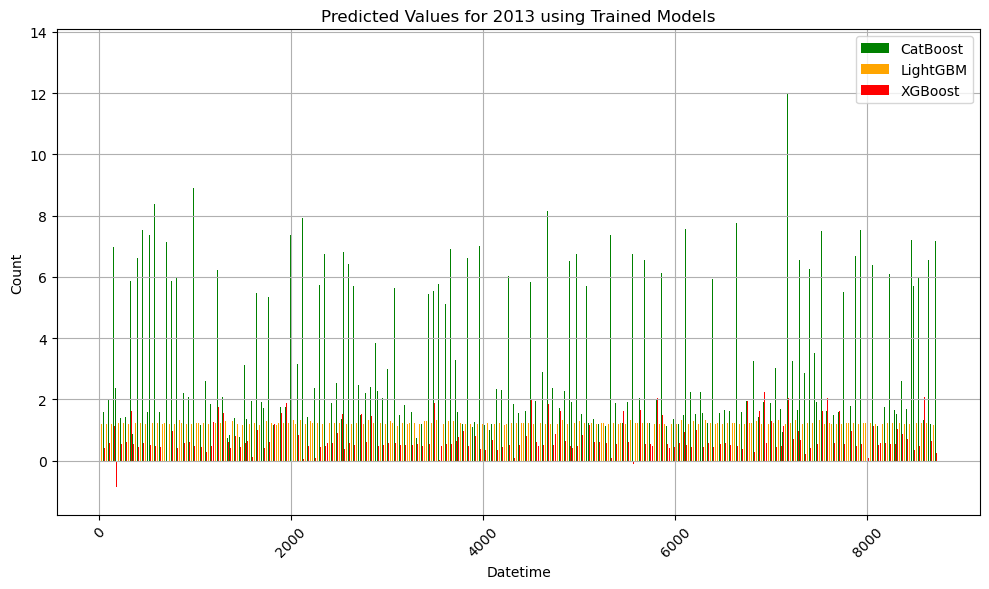

In [33]:
import matplotlib.pyplot as plt

# Assuming test_2013_data is the DataFrame containing the features for 2013

# Plot predicted values for each model using bar graphs
plt.figure(figsize=(10, 6))

# Define the positions of the bars
bar_width = 0.2
index = test_2013_data.index

# Plot CatBoost predictions
plt.bar(index - bar_width, cat_pred_2013, width=bar_width, label='CatBoost', color='green')

# Plot LightGBM predictions
plt.bar(index, lgbm_pred_2013, width=bar_width, label='LightGBM', color='orange')

# Plot XGBoost predictions
plt.bar(index + bar_width, xgb_pred_2013, width=bar_width, label='XGBoost', color='red')

plt.xlabel('Datetime')
plt.ylabel('Count')
plt.title('Predicted Values for 2013 using Trained Models')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


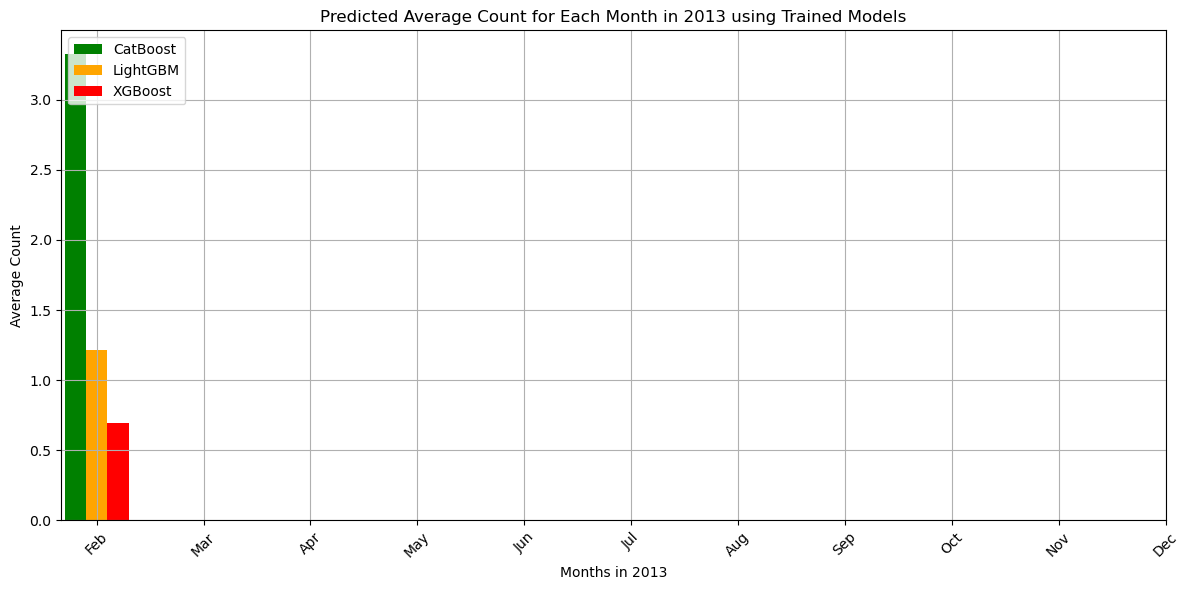

In [34]:
import calendar
import numpy as np
import matplotlib.pyplot as plt

# Assuming test_2013_data is the DataFrame containing the features for 2013

# Step 4: Make predictions for 2013 using the trained models
test_2013_data = test_2013_data[X_train.columns]

# Test data should have a datetime index
test_2013_data.index = pd.to_datetime(test_2013_data.index)

# Make predictions for 2013 using the trained models
cat_pred_2013 = cat_model.predict(test_2013_data)
lgbm_pred_2013 = lgbm_model.predict(test_2013_data)
xgb_pred_2013 = xgb_model.predict(test_2013_data)

# Get month names
month_names = [calendar.month_abbr[i] for i in range(1, 13)]

# Aggregate predictions by month
monthly_cat_pred = []
monthly_lgbm_pred = []
monthly_xgb_pred = []

for month in range(1, 13):
    month_indices = (test_2013_data.index.month == month)
    monthly_cat_pred.append(np.mean(cat_pred_2013[month_indices]))
    monthly_lgbm_pred.append(np.mean(lgbm_pred_2013[month_indices]))
    monthly_xgb_pred.append(np.mean(xgb_pred_2013[month_indices]))

# Plot predicted counts as a bar graph for each month in 2013
plt.figure(figsize=(12, 6))

# Define the positions of the bars
bar_width = 0.2
index = np.arange(1, 13)

# Plot CatBoost predictions
plt.bar(index - bar_width, monthly_cat_pred, width=bar_width, label='CatBoost', color='green')

# Plot LightGBM predictions
plt.bar(index, monthly_lgbm_pred, width=bar_width, label='LightGBM', color='orange')

# Plot XGBoost predictions
plt.bar(index + bar_width, monthly_xgb_pred, width=bar_width, label='XGBoost', color='red')

plt.xlabel('Months in 2013')
plt.ylabel('Average Count')
plt.title('Predicted Average Count for Each Month in 2013 using Trained Models')
plt.legend()
plt.grid(True)
plt.xticks(ticks=np.arange(1, 12), labels=month_names[1:], rotation=45)

plt.tight_layout()
plt.show()


In [35]:
print("Shape of test_2013_data:", test_2013_data.shape)
print("Shape of cat_pred_2013:", cat_pred_2013.shape)
print("Shape of lgbm_pred_2013:", lgbm_pred_2013.shape)
print("Shape of xgb_pred_2013:", xgb_pred_2013.shape)


Shape of test_2013_data: (8737, 14)
Shape of cat_pred_2013: (8737,)
Shape of lgbm_pred_2013: (8737,)
Shape of xgb_pred_2013: (8737,)


In [36]:
import pandas as pd

# Assuming df is your DataFrame
column_names = test_2013_data.columns.tolist()
print(column_names)


['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'year', 'month', 'day', 'hour']


Mean Absolute Error (MAE) for each model:
CatBoost: 3.327841362514486
LightGBM: 1.2178663725825623
XGBoost: 0.7004046571951172

Root Mean Squared Error (RMSE) for each model:
CatBoost: 4.084095806850863
LightGBM: 1.2184661132089134
XGBoost: 0.8416124208370328


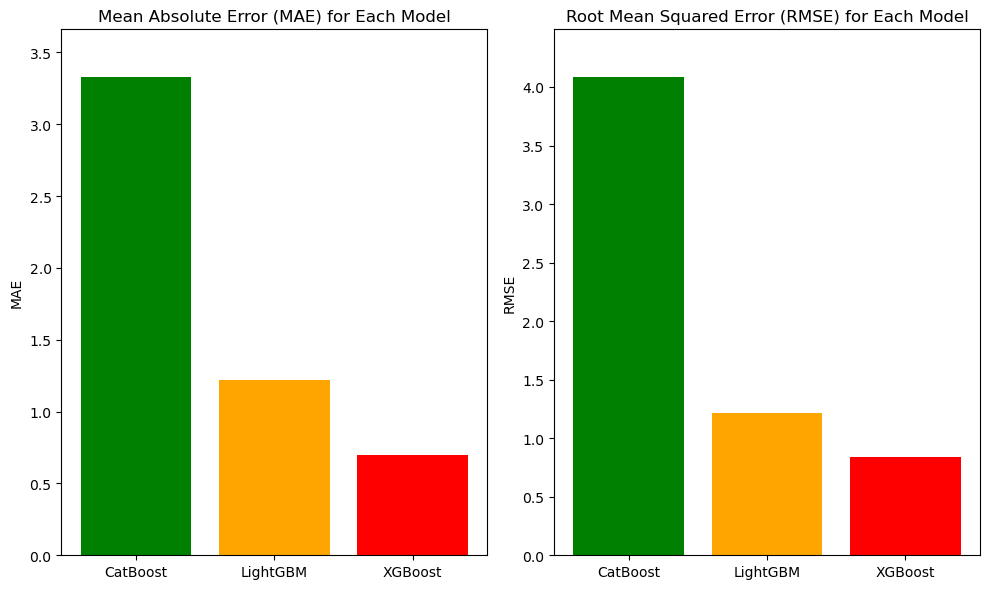

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate the predicted counts by summing 'casual' and 'registered' columns
predicted_counts = test_2013_data['casual'] + test_2013_data['registered']

# Calculate Mean Absolute Error (MAE) for each model
cat_mae = mean_absolute_error(predicted_counts, cat_pred_2013)
lgbm_mae = mean_absolute_error(predicted_counts, lgbm_pred_2013)
xgb_mae = mean_absolute_error(predicted_counts, xgb_pred_2013)

# Calculate Root Mean Squared Error (RMSE) for each model
cat_rmse = mean_squared_error(predicted_counts, cat_pred_2013, squared=False)
lgbm_rmse = mean_squared_error(predicted_counts, lgbm_pred_2013, squared=False)
xgb_rmse = mean_squared_error(predicted_counts, xgb_pred_2013, squared=False)

# Print accuracy values
print("Mean Absolute Error (MAE) for each model:")
print("CatBoost:", cat_mae)
print("LightGBM:", lgbm_mae)
print("XGBoost:", xgb_mae)
print("\nRoot Mean Squared Error (RMSE) for each model:")
print("CatBoost:", cat_rmse)
print("LightGBM:", lgbm_rmse)
print("XGBoost:", xgb_rmse)

# Plotting the metrics
models = ['CatBoost', 'LightGBM', 'XGBoost']
mae_values = [cat_mae, lgbm_mae, xgb_mae]
rmse_values = [cat_rmse, lgbm_rmse, xgb_rmse]

plt.figure(figsize=(10, 6))

# Plot MAE
plt.subplot(1, 2, 1)
plt.bar(models, mae_values, color=['green', 'orange', 'red'])
plt.title('Mean Absolute Error (MAE) for Each Model')
plt.ylabel('MAE')
plt.ylim(0, max(mae_values) * 1.1)

# Plot RMSE
plt.subplot(1, 2, 2)
plt.bar(models, rmse_values, color=['green', 'orange', 'red'])
plt.title('Root Mean Squared Error (RMSE) for Each Model')
plt.ylabel('RMSE')
plt.ylim(0, max(rmse_values) * 1.1)

plt.tight_layout()
plt.show()


# prediction for 2013 using LSTM_Model

In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [40]:
# Load train and test datasets
# Replace 'train_dataset.csv' and 'test_dataset.csv' with the actual file paths
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


In [41]:
# Preprocess the data
train_data['datetime'] = pd.to_datetime(train_data['datetime'])
test_data['datetime'] = pd.to_datetime(test_data['datetime'])

# Filter train data for years 2011 and 2012
train_data_2011_2012 = train_data[(train_data['datetime'].dt.year == 2011) | (train_data['datetime'].dt.year == 2012)]

# Select relevant columns
train_data_2011_2012 = train_data_2011_2012[['datetime', 'weather', 'count']]
test_data = test_data[['datetime', 'weather']]

# Normalize count values
scaler = MinMaxScaler()
train_data_2011_2012['count_normalized'] = scaler.fit_transform(train_data_2011_2012[['count']])


In [42]:
# Prepare data for LSTM model
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 24  # Number of hours to consider
X_train, y_train = create_dataset(train_data_2011_2012[['count_normalized']], train_data_2011_2012['count_normalized'], TIME_STEPS)
X_test, y_test = create_dataset(test_data[['weather']], test_data['weather'], TIME_STEPS)


In [43]:
# Define and train the LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)



Epoch 1/20

679/679 [==============================] - 7s 7ms/step - loss: 0.0145
Epoch 2/20
679/679 [==============================] - 8s 12ms/step - loss: 0.0066
Epoch 3/20
679/679 [==============================] - 8s 12ms/step - loss: 0.0061
Epoch 4/20
679/679 [==============================] - 8s 12ms/step - loss: 0.0057
Epoch 5/20
679/679 [==============================] - 8s 12ms/step - loss: 0.0052
Epoch 6/20
679/679 [==============================] - 8s 12ms/step - loss: 0.0041
Epoch 7/20
679/679 [==============================] - 8s 12ms/step - loss: 0.0036
Epoch 8/20
679/679 [==============================] - 8s 12ms/step - loss: 0.0034
Epoch 9/20
679/679 [==============================] - 8s 12ms/step - loss: 0.0031
Epoch 10/20
679/679 [==============================] - 10s 14ms/step - loss: 0.0030
Epoch 11/20
679/679 [==============================] - 10s 15ms/step - loss: 0.0029
Epoch 12/20
679/679 [==============================] - 10s 15ms/step - loss: 0.0028
Epoch 13

In [44]:
# Make predictions
y_pred = model.predict(X_test)


203/203 [==============================] - 1s 4ms/step


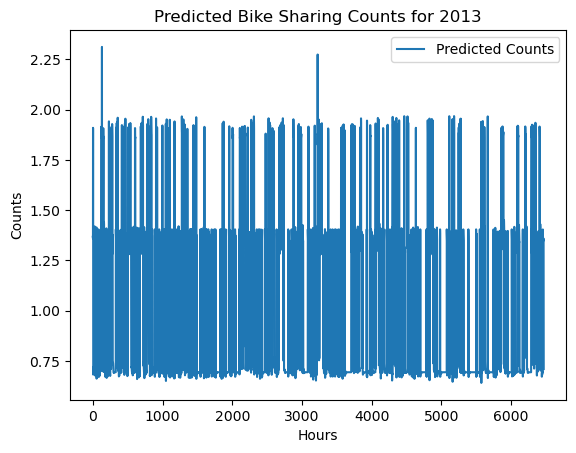

In [45]:
# Plotting predictions for 2013
plt.plot(y_pred, label='Predicted Counts')
plt.xlabel('Hours')
plt.ylabel('Counts')
plt.title('Predicted Bike Sharing Counts for 2013')
plt.legend()
plt.show()

In [46]:
# Rescale predicted counts
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Extract months from datetime
test_data['month'] = test_data['datetime'].dt.month

In [47]:
# Trim or pad y_pred_rescaled to match the length of test_data['month']
y_pred_rescaled = np.pad(y_pred_rescaled, (0, len(test_data) - len(y_pred_rescaled)), mode='constant')


In [48]:


# Plotting predictions for 2013
plt.figure(figsize=(12, 6))


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

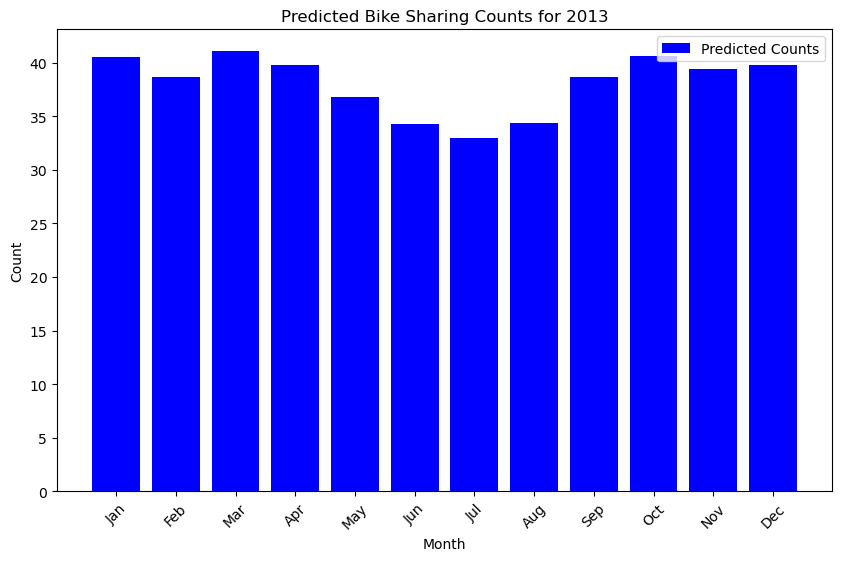

In [49]:
import calendar
import numpy as np
import matplotlib.pyplot as plt

# Get month names
month_names = [calendar.month_abbr[i] for i in range(1, 13)]

# Aggregate predictions by month
monthly_predictions = []
for month in range(1, 13):
    monthly_data = y_pred_rescaled[test_data['month'] == month]
    monthly_predictions.append(np.mean(monthly_data))

# Plot predicted counts as a bar graph for a specific feature (e.g., 'season')
plt.figure(figsize=(10, 6))
plt.bar(month_names, monthly_predictions, label='Predicted Counts', color='blue')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Predicted Bike Sharing Counts for 2013')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(loc='upper right')
plt.show()


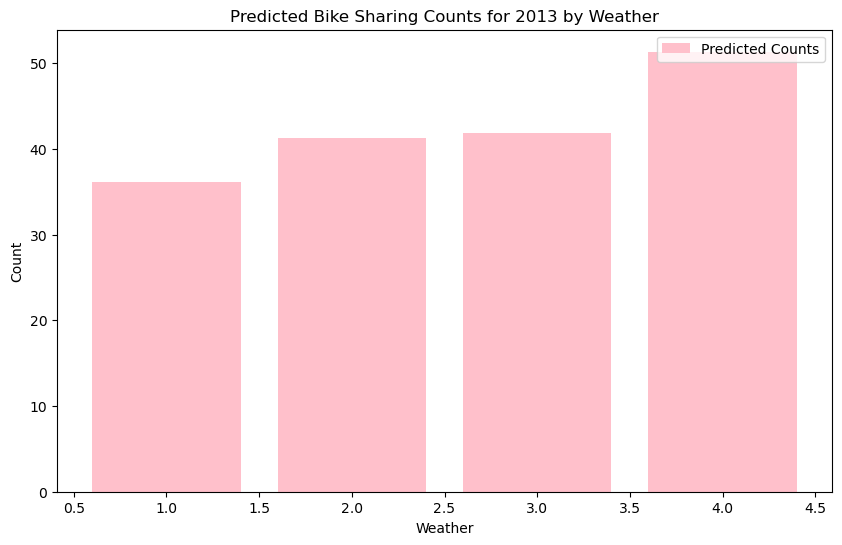

In [50]:
import calendar
import numpy as np
import matplotlib.pyplot as plt

# Get unique weather categories
weather_categories = np.unique(test_data['weather'])

# Aggregate predictions by weather category
weather_predictions = []
for weather_cat in weather_categories:
    weather_data = y_pred_rescaled[test_data['weather'] == weather_cat]
    weather_predictions.append(np.mean(weather_data))

# Plot predicted counts as a bar graph for weather
plt.figure(figsize=(10, 6))
plt.bar(weather_categories, weather_predictions, label='Predicted Counts', color='pink')
plt.xlabel('Weather')
plt.ylabel('Count')
plt.title('Predicted Bike Sharing Counts for 2013 by Weather')
plt.legend(loc='upper right')
plt.show()


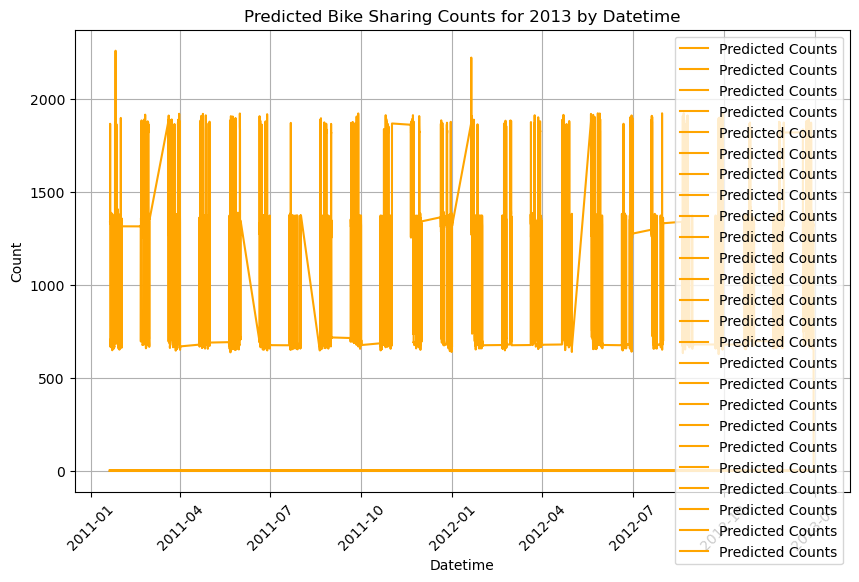

In [51]:
import matplotlib.pyplot as plt

# Aggregate predictions by datetime
datetime_predictions = []
for datetime_point in test_data['datetime']:
    # Convert datetime to index
    idx = test_data[test_data['datetime'] == datetime_point].index[0]
    datetime_data = y_pred_rescaled[idx]
    datetime_predictions.append(datetime_data)

# Plot predicted counts as a line graph for datetime
plt.figure(figsize=(10, 6))
plt.plot(test_data['datetime'], datetime_predictions, label='Predicted Counts', color='orange')
plt.xlabel('Datetime')
plt.ylabel('Count')
plt.title('Predicted Bike Sharing Counts for 2013 by Datetime')
plt.legend(loc='upper right')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.show()


In [52]:
from sklearn.metrics import mean_squared_error

# Assuming y_test contains the actual counts and y_pred contains the predicted counts
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 0.38950859190255194


In [53]:
import numpy as np

# Assuming you have the predictions (y_pred) and actual target values (y_test) for 2013
# Replace y_pred_2013 and y_test with your actual predictions and target values
# Compute the RMSLE
def rmsle(y_test, y_pred):
    assert len(y_test) == len(y_pred)
    squared_log_error = (np.log1p(y_pred) - np.log1p(y_test))**2
    rmsle = np.sqrt(np.mean(squared_log_error))
    return rmsle

# Calculate RMSLE for 2013 data
rmsle_2013 = rmsle(y_test, y_pred)
print("RMSLE for 2013 data:", rmsle_2013)


RMSLE for 2013 data: 0.3634001175681042


In [54]:
y_test_lstm=y_test
lstm_pred=y_pred

In [55]:
# Assuming you have the predictions for cat_model, lgbm_model, xgb_model, and LSTM model stored in cat_pred, lgbm_pred, xgb_pred, and lstm_pred respectively

# Calculate absolute errors for each model
abs_error_cat = np.abs(y_final - cat_pred)
abs_error_lgbm = np.abs(y_final - lgbm_pred)
abs_error_xgb = np.abs(y_final - xgb_pred)
abs_error_lstm = np.abs(y_test_lstm - lstm_pred)

# Calculate mean absolute errors (MAE) for each model
mae_cat = np.mean(abs_error_cat)
mae_lgbm = np.mean(abs_error_lgbm)
mae_xgb = np.mean(abs_error_xgb)
mae_lstm = np.mean(abs_error_lstm)

# Calculate percentage errors relative to the total count of test samples
total_samples_boost = len(y_final)
total_samples_lstm = len(y_test_lstm)

percentage_error_cat = (mae_cat / total_samples_boost) * 100
percentage_error_lgbm = (mae_lgbm / total_samples_boost) * 100
percentage_error_xgb = (mae_xgb / total_samples_boost) * 100
percentage_error_lstm = (mae_lstm / total_samples_lstm) * 100

# Print the results
print("Percentage error for cat_model:", percentage_error_cat)
print("Percentage error for lgbm_model:", percentage_error_lgbm)
print("Percentage error for xgb_model:", percentage_error_xgb)
print("Percentage error for LSTM model:", percentage_error_lstm)


Percentage error for cat_model: 0.09317258792936595
Percentage error for lgbm_model: 0.18728234182260067
Percentage error for xgb_model: 0.13958731367305535
Percentage error for LSTM model: 0.010596490910570943


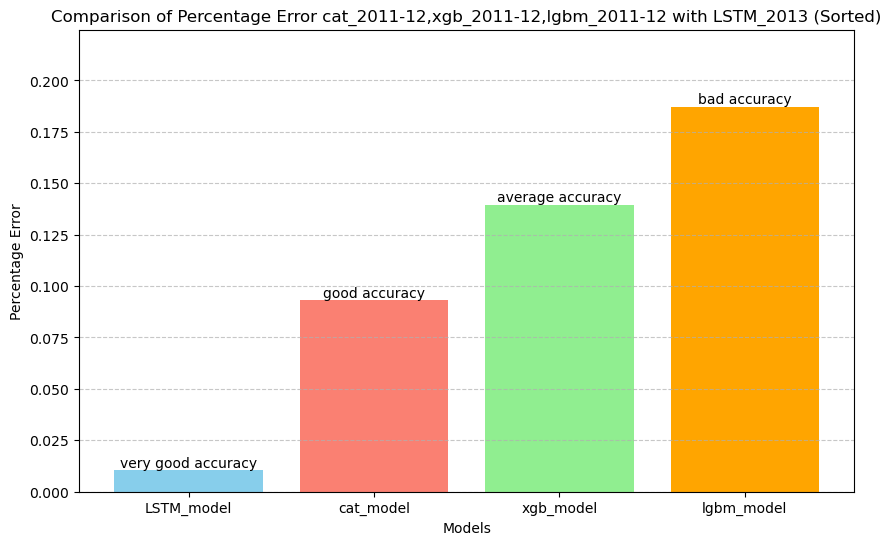

In [63]:
import matplotlib.pyplot as plt

# Data
models = ['cat_model', 'lgbm_model', 'xgb_model', 'LSTM_model']
errors = [percentage_error_cat, percentage_error_lgbm, percentage_error_xgb, percentage_error_lstm]

# Sort models and errors based on errors
sorted_indices = sorted(range(len(errors)), key=lambda i: errors[i])
sorted_models = [models[i] for i in sorted_indices]
sorted_errors = [errors[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_models, sorted_errors, color=['skyblue', 'salmon', 'lightgreen', 'orange'])
plt.xlabel('Models')
plt.ylabel('Percentage Error')
plt.title('Comparison of Percentage Error cat_2011-12,xgb_2011-12,lgbm_2011-12 with LSTM_2013 (Sorted)')
plt.ylim(0, max(sorted_errors) * 1.2)  # Set ylim to 20% more than the maximum error for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Define annotation messages
annotations = ['very good accuracy', 'good accuracy','average accuracy',  'bad accuracy']

# Add annotations indicating accuracy
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), annotations[i], ha='center', va='bottom', color='black', fontsize=10)

plt.show()


# LSTM_2013  VS cat_2013,xgb_2013,lgbm_2013

Mean Absolute Error (MAE) for each model:
CatBoost: 3.327841362514486
LightGBM: 1.2178663725825623
XGBoost: 0.7004046571951172
LSTM: 0.5076587881716128

Root Mean Squared Error (RMSE) for each model:
CatBoost: 4.084095806850863
LightGBM: 1.2184661132089134
XGBoost: 0.8416124208370328
LSTM: 0.6241062344685814


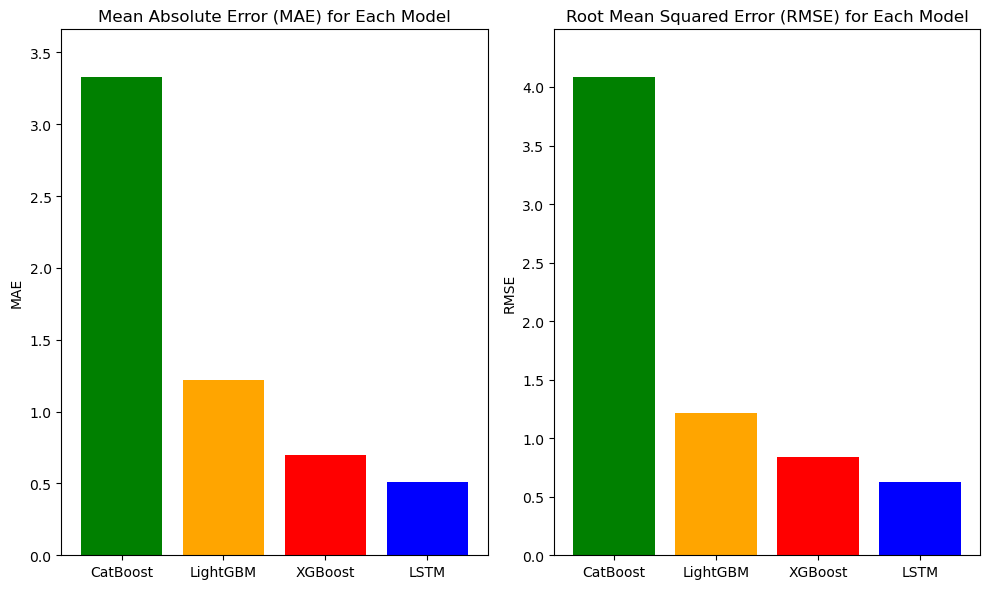

In [58]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate the predicted counts by summing 'casual' and 'registered' columns
predicted_counts = test_2013_data['casual'] + test_2013_data['registered']

# Calculate Mean Absolute Error (MAE) for each model
cat_mae = mean_absolute_error(predicted_counts, cat_pred_2013)
lgbm_mae = mean_absolute_error(predicted_counts, lgbm_pred_2013)
xgb_mae = mean_absolute_error(predicted_counts, xgb_pred_2013)
lstm_mae = mean_absolute_error(y_test_lstm, lstm_pred)

# Calculate Root Mean Squared Error (RMSE) for each model
cat_rmse = mean_squared_error(predicted_counts, cat_pred_2013, squared=False)
lgbm_rmse = mean_squared_error(predicted_counts, lgbm_pred_2013, squared=False)
xgb_rmse = mean_squared_error(predicted_counts, xgb_pred_2013, squared=False)
lstm_rmse = mean_squared_error(y_test_lstm, lstm_pred, squared=False)

# Print accuracy values
print("Mean Absolute Error (MAE) for each model:")
print("CatBoost:", cat_mae)
print("LightGBM:", lgbm_mae)
print("XGBoost:", xgb_mae)
print("LSTM:", lstm_mae)
print("\nRoot Mean Squared Error (RMSE) for each model:")
print("CatBoost:", cat_rmse)
print("LightGBM:", lgbm_rmse)
print("XGBoost:", xgb_rmse)
print("LSTM:", lstm_rmse)

# Plotting the metrics
models = ['CatBoost', 'LightGBM', 'XGBoost', 'LSTM']
mae_values = [cat_mae, lgbm_mae, xgb_mae, lstm_mae]
rmse_values = [cat_rmse, lgbm_rmse, xgb_rmse, lstm_rmse]

plt.figure(figsize=(10, 6))

# Plot MAE
plt.subplot(1, 2, 1)
plt.bar(models, mae_values, color=['green', 'orange', 'red', 'blue'])
plt.title('Mean Absolute Error (MAE) for Each Model')
plt.ylabel('MAE')
plt.ylim(0, max(mae_values) * 1.1)

# Plot RMSE
plt.subplot(1, 2, 2)
plt.bar(models, rmse_values, color=['green', 'orange', 'red', 'blue'])
plt.title('Root Mean Squared Error (RMSE) for Each Model')
plt.ylabel('RMSE')
plt.ylim(0, max(rmse_values) * 1.1)

plt.tight_layout()
plt.show()


Mean Absolute Error (MAE) for each model:
CatBoost: 3.327841362514486
LightGBM: 1.2178663725825623
XGBoost: 0.7004046571951172
LSTM: 0.5076587881716128

Root Mean Squared Error (RMSE) for each model:
CatBoost: 4.084095806850863
LightGBM: 1.2184661132089134
XGBoost: 0.8416124208370328
LSTM: 0.6241062344685814


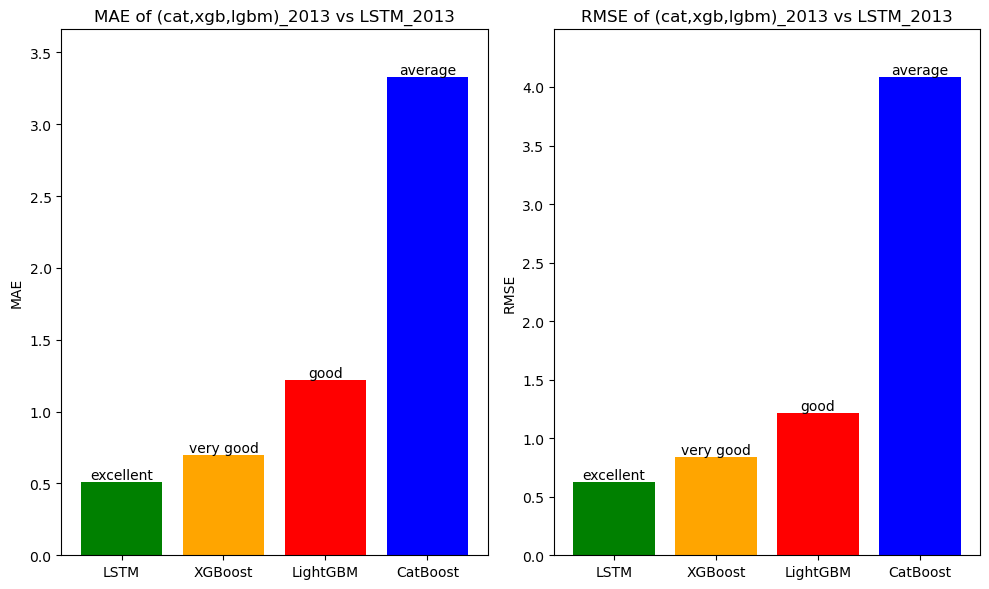

In [66]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate the predicted counts by summing 'casual' and 'registered' columns
predicted_counts = test_2013_data['casual'] + test_2013_data['registered']

# Calculate Mean Absolute Error (MAE) for each model
cat_mae = mean_absolute_error(predicted_counts, cat_pred_2013)
lgbm_mae = mean_absolute_error(predicted_counts, lgbm_pred_2013)
xgb_mae = mean_absolute_error(predicted_counts, xgb_pred_2013)
lstm_mae = mean_absolute_error(y_test_lstm, lstm_pred)

# Calculate Root Mean Squared Error (RMSE) for each model
cat_rmse = mean_squared_error(predicted_counts, cat_pred_2013, squared=False)
lgbm_rmse = mean_squared_error(predicted_counts, lgbm_pred_2013, squared=False)
xgb_rmse = mean_squared_error(predicted_counts, xgb_pred_2013, squared=False)
lstm_rmse = mean_squared_error(y_test_lstm, lstm_pred, squared=False)

# Print accuracy values
print("Mean Absolute Error (MAE) for each model:")
print("CatBoost:", cat_mae)
print("LightGBM:", lgbm_mae)
print("XGBoost:", xgb_mae)
print("LSTM:", lstm_mae)
print("\nRoot Mean Squared Error (RMSE) for each model:")
print("CatBoost:", cat_rmse)
print("LightGBM:", lgbm_rmse)
print("XGBoost:", xgb_rmse)
print("LSTM:", lstm_rmse)

# Plotting the metrics
models = ['CatBoost', 'LightGBM', 'XGBoost', 'LSTM']
mae_values = [cat_mae, lgbm_mae, xgb_mae, lstm_mae]
rmse_values = [cat_rmse, lgbm_rmse, xgb_rmse, lstm_rmse]

# Sort models based on MAE values
models_sorted = [x for _, x in sorted(zip(mae_values, models))]
mae_values_sorted = sorted(mae_values)
rmse_values_sorted = [rmse_values[models.index(model)] for model in models_sorted]

plt.figure(figsize=(10, 6))

# Plot MAE
plt.subplot(1, 2, 1)
plt.bar(models_sorted, mae_values_sorted, color=['green', 'orange', 'red', 'blue'])
plt.title('MAE of (cat,xgb,lgbm)_2013 vs LSTM_2013')
plt.ylabel('MAE')
plt.ylim(0, max(mae_values) * 1.1)

# Add annotations for MAE
annotations = ['excellent', 'very good','good',  'average']
for i, label in enumerate(annotations):
    plt.text(i, mae_values_sorted[i], label, ha='center', va='bottom')

# Plot RMSE
plt.subplot(1, 2, 2)
plt.bar(models_sorted, rmse_values_sorted, color=['green', 'orange', 'red', 'blue'])
plt.title('RMSE of (cat,xgb,lgbm)_2013 vs LSTM_2013')
plt.ylabel('RMSE')
plt.ylim(0, max(rmse_values) * 1.1)

# Add annotations for RMSE
for i, label in enumerate(annotations):
    plt.text(i, rmse_values_sorted[i], label, ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [57]:
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from mlxtend.regressor import StackingCVRegressor
#from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from scipy.stats import probplot
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from scipy.special import boxcox1p, inv_boxcox1p
from scipy.stats import boxcox_normmax
import math
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
#sample_submission = pd.read_csv('/kaggle/input/bike-sharing-demand/sampleSubmission.csv')

data = pd.concat([df_train, df_test], axis = 0)
data.reset_index(drop = True, inplace = True)

data.head()

data['hour'] = data['datetime'].str.split(' ', expand = True)[1].str.split(':', expand = True)[0].astype(int).astype('category')
df_train['hour'] = df_train['datetime'].str.split(' ', expand = True)[1].str.split(':', expand = True)[0].astype(int).astype('category')
df_test['hour'] = df_test['datetime'].str.split(' ', expand = True)[1].str.split(':', expand = True)[0].astype(int).astype('category')

data['month'] = data['datetime'].str.split(' ', expand = True)[0].str.split('-', expand = True)[1].astype(int).astype('category')
df_train['month'] = df_train['datetime'].str.split(' ', expand = True)[0].str.split('-', expand = True)[1].astype(int).astype('category')
df_test['month'] = df_test['datetime'].str.split(' ', expand = True)[0].str.split('-', expand = True)[1].astype(int).astype('category')

data['day'] = data['datetime'].str.split(' ', expand = True)[0].str.split('-', expand = True)[2].astype(int).astype('category')
df_train['day'] = df_train['datetime'].str.split(' ', expand = True)[0].str.split('-', expand = True)[2].astype(int).astype('category')
df_test['day'] = df_test['datetime'].str.split(' ', expand = True)[0].str.split('-', expand = True)[2].astype(int).astype('category')

data['year'] = data['datetime'].str.split(' ', expand = True)[0].str.split('-', expand = True)[0].astype(int).map({2011: 0, 2012:1}).astype('category')
df_train['year'] = df_train['datetime'].str.split(' ', expand = True)[0].str.split('-', expand = True)[0].astype(int).map({2011: 0, 2012:1}).astype('category')
df_test['year'] = df_test['datetime'].str.split(' ', expand = True)[0].str.split('-', expand = True)[0].astype(int).map({2011: 0, 2012:1}).astype('category')

data['season'] = data['season'].astype('category')
data['holiday'] = data['holiday'].astype('category')
data['workingday'] = data['workingday'].astype('category')
data['weather'] = data['weather'].astype('category')

data.info()

num_feature = data.select_dtypes(include = ['int64', 'float64']).columns.to_list()
cat_feature = data.select_dtypes(include = 'category').columns.to_list()

num_feature, cat_feature

print("Skew of Count in training data: ", df_train['count'].skew())
print("Kurtosis of Count in training data: " , df_train['count'].kurt())
print("Mean of Count in training data: ", df_train['count'].mean())
print("Median of Count in training data: ", df_train['count'].median())

fig, ax = plt.subplots(nrows = 1, figsize = (7, 7))
plt.subplots_adjust(hspace = 0.5)

sns.histplot(df_train['count'], kde = True, ax = ax)

ax.set_title('Distribution of count in training data');

fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (25, 20))

for i, feature in enumerate(num_feature, 1):
    plt.subplot(4, 2, i)
    
    sns.histplot(df_train[feature], kde = True)
    
    plt.legend(loc = 'best')
    

fig.delaxes(ax[3][1])
fig.delaxes(ax[3][0])

corr_map = data[num_feature].corr()

fig, ax = plt.subplots(figsize = (6, 6))

sns.heatmap(corr_map, square = True, annot = True, cmap = 'coolwarm', ax = ax, cbar_kws = {'shrink': 0.8})
ax.set_title('Correlation Between Numerical Variable');

from sklearn.feature_selection import f_regression

f_stats, p_score = f_regression(df_train[cat_feature], df_train['count'])

score_chart = pd.DataFrame({'Feature': cat_feature, 'f_statistics': f_stats.round(2), 'P_Value': p_score.round(2)})

score_chart

fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (25, 20))

for i, feature in enumerate(num_feature, 1):
    plt.subplot(4, 2, i)
    
    sns.scatterplot(df_train, x = feature, y = 'count', hue = 'count', size = 'count')
    
    plt.legend(loc = 'best')
    

fig.delaxes(ax[3][1])
fig.delaxes(ax[3][0])

fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (25, 20))

for i, feature in enumerate(num_feature, 1):
    plt.subplot(4, 2, i)
    
    sns.boxplot(df_train, x = feature)
    
    plt.legend(loc = 'best')
    

fig.delaxes(ax[3][1])
# fig.delaxes(ax[3][0])

fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (25, 20))

for i, feature in enumerate(cat_feature, 1):
    plt.subplot(4, 2, i)
    
    sns.boxplot(df_train, x = feature, y = 'count', orient = 'v')
    
    
num_feature_ex = ['temp', 'atemp', 'humidity', 'windspeed']

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (25, 20))

for i, feature in enumerate(num_feature_ex, 1):
    plt.subplot(2, 2, i)
    
    sns.kdeplot(data.loc[data['count'].notnull()], x = feature, shade = True, label = 'Train')
    sns.kdeplot(data.loc[data['count'].isnull()], x = feature, shade = True, label = 'Test')
    
    plt.legend(loc = 1)
    
    
    data['Train'] = 'Train'
data.loc[data['count'].isnull(), 'Train'] = 'Test'

fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (25, 20))

for i, feature in enumerate(cat_feature, 1):
    plt.subplot(4, 2, i)
    
    sns.countplot(data, x = feature, hue = 'Train')
    
    plt.legend(loc = 1)
    

fig.delaxes(ax[3][1])

data.drop(['Train'], axis = 1, inplace = True)

def OrdEncode(feature, target):
    ke = data.groupby(feature)[target].mean().sort_values().to_dict().keys()
    
    hour_map = dict({})
    cnt = 1
    
    for key in ke:
        hour_map[key] = cnt
        cnt+=1
    
    return hour_map
    
data.loc[data['humidity'] == 0, 'humidity'] = np.nan

df = data.copy()

#Ordinal Encoding
df['hour'] = df['hour'].map(OrdEncode('hour', 'humidity'))

#One Hot Encoding
encode = pd.get_dummies(df[['month', 'season']].astype('str'), dtype = int, drop_first = True)
df = pd.concat([df, encode], axis = 1)

df.drop(['month', 'weather', 'season', 'holiday', 'workingday', 'day', 'datetime', 'casual', 'registered', 'temp', 'atemp', 'windspeed', 'year'], axis = 1, inplace = True)

#Train the imputer
cat_imputer = make_pipeline(StandardScaler(), CatBoostRegressor(depth = 10, iterations = 200, learning_rate =  0.1, logging_level="Silent"))

x_imputer = df.loc[df['humidity'].notnull()].drop('humidity', axis = 1)
y_imputer = df.loc[df['humidity'].notnull(), 'humidity']

test_imputer = df.loc[df['humidity'].isnull()].drop('humidity', axis = 1)

cat_imputer.fit(x_imputer, y_imputer)

#Fill the missing value
data.loc[data['humidity'].isnull(), 'humidity'] = cat_imputer.predict(test_imputer)

#Ordinal Encoding
data['hour'] = data['hour'].map(OrdEncode('hour', 'count'))

#One Hot Encoding
encode = pd.get_dummies(data[['month', 'weather', 'season', 'workingday', 'day']].astype('str'), dtype = int, drop_first = True)
data = pd.concat([data, encode], axis = 1)

data.drop(['month', 'weather', 'season', 'holiday', 'day', 'workingday', 'datetime', 'casual', 'registered'], axis = 1, inplace = True)
data.head()

x = data.loc[data['count'].notnull()].drop('count', axis = 1)

test_data = data.loc[data['count'].isnull()].drop('count', axis = 1)

y = data.loc[data['count'].notnull(), 'count']

def cross_val(model, x, y):
    
    KF = KFold(n_splits = 5, shuffle = True, random_state = 42)
    fold = 0
    scores = []
    
    for train_index, test_index in KF.split(x, y):
        
        fold += 1
        
        x_train = x[train_index]
        y_train = y[train_index]
        
        x_test = x[test_index]
        y_test = y[test_index]
                
        #box cox transformation to the target variable
        lamb = boxcox_normmax(y_train)
        y_train = boxcox1p(y_train, lamb)
        
        model.fit(x_train, y_train)
        
        #inverse box cox transformation to the predicted value
        y_pred = np.clip(inv_boxcox1p(model.predict(x_test), lamb).round(0).astype(int), a_min = 0, a_max = np.inf)

        scores.append(np.sqrt(mean_squared_log_error(y_pred, y_test)))
        
        print(f"RMSLE score for {fold} fold: {np.sqrt(mean_squared_log_error(y_pred, y_test))}")
        
    print(f"Final Score: {np.mean(scores)}")
    
#CatBoost
cat_model = make_pipeline(StandardScaler(), CatBoostRegressor(depth = 10, iterations = 200, learning_rate =  0.1, logging_level="Silent"))

cross_val(cat_model, x.values, y.values)

pip install lightgbm

#LGBM Regressor
from lightgbm import LGBMRegressor
lgbm_model = make_pipeline(StandardScaler(), LGBMRegressor(objective = 'regression', bagging_fraction = 0.75, bagging_freq = 5, bagging_seed = 42, feature_fraction = 0.6, feature_fraction_seed = 42, learning_rate = 0.1, max_bin = 200, n_estimators = 3000, num_leaves = 14, verbose = -1))

cross_val(lgbm_model, x.values, y.values)

#XGBoost Regressor
xgb_model = XGBRegressor(objective = 'reg:squaredlogerror', colsample_bytree = 0.7, gamma = 0.001, learning_rate = 0.1, max_depth = 8, n_estimators = 2000, nthread = -1, reg_alpha = 0.01, seed = 42, subsample = 0.95, enable_categorical = True)

cross_val(xgb_model, x.values, y.values)

def cross_val_blending(cat, lgbm, xgb, x, y, p1, p2, p3):
    
    KF = KFold(n_splits = 5, shuffle = True, random_state = 42)
    fold = 0
    scores = []
    
    for train_index, test_index in KF.split(x, y):
        
        fold += 1
        
        x_train = x[train_index]
        y_train = y[train_index]
        
        x_test = x[test_index]
        y_test = y[test_index] 
        
        #box cox transformation to the target variable
        lamb = boxcox_normmax(y_train)
        y_train = boxcox1p(y_train, lamb)
        
        cat.fit(x_train, y_train)
        lgbm.fit(x_train, y_train)
        xgb.fit(x_train, y_train)
        
        #inverse box cox transformation to the predicted value
        cat_pred = inv_boxcox1p(cat_model.predict(x_test), lamb)
        lgbm_pred = inv_boxcox1p(lgbm_model.predict(x_test), lamb)
        xgb_pred = inv_boxcox1p(xgb_model.predict(x_test), lamb)
        
        y_final = (p1 * cat_pred) + (p2 * lgbm_pred) + ((p3) * xgb_pred)
        y_final = np.clip(y_final.round(0).astype(int), a_min = 0, a_max = np.inf)

        scores.append(np.sqrt(mean_squared_log_error(y_final, y_test)))
        
        print(f"RMSLE score for {fold} fold: {np.sqrt(mean_squared_log_error(y_final, y_test))}")
        
    print(f"Final Score: {np.mean(scores)}")
    
cat_model = make_pipeline(StandardScaler(), CatBoostRegressor(depth = 10, iterations = 200, learning_rate =  0.1, logging_level="Silent"))
lgbm_model = make_pipeline(StandardScaler(), LGBMRegressor(objective = 'regression', bagging_fraction = 0.75, bagging_freq = 5, bagging_seed = 42, feature_fraction = 0.6, feature_fraction_seed = 42, learning_rate = 0.1, max_bin = 200, n_estimators = 3000, num_leaves = 14, verbose = -1))
xgb_model = XGBRegressor(objective = 'reg:squaredlogerror', colsample_bytree = 0.7, gamma = 0.001, learning_rate = 0.1, max_depth = 8, n_estimators = 2000, nthread = -1, reg_alpha = 0.01, seed = 42, subsample = 0.95, enable_categorical = True)

cross_val_blending(cat_model, lgbm_model, xgb_model, x.values, y.values, 0.6, 0, 0.4)

#import pandas as pd

#sample_submission = pd.read_csv('/kaggle/input/bike-sharing-demand/sampleSubmission.csv')


cat_model = make_pipeline(StandardScaler(), CatBoostRegressor(depth = 10, iterations = 200, learning_rate =  0.1, logging_level="Silent"))
lgbm_model = make_pipeline(StandardScaler(), LGBMRegressor(objective = 'regression', bagging_fraction = 0.75, bagging_freq = 5, bagging_seed = 42, feature_fraction = 0.6, feature_fraction_seed = 42, learning_rate = 0.1, max_bin = 200, n_estimators = 3000, num_leaves = 14, verbose = -1))
xgb_model = XGBRegressor(objective = 'reg:squaredlogerror', colsample_bytree = 0.7, gamma = 0.001, learning_rate = 0.1, max_depth = 8, n_estimators = 2000, nthread = -1, reg_alpha = 0.01, seed = 42, subsample = 0.95, enable_categorical = True)

lamb = boxcox_normmax(y)
y = boxcox1p(y, lamb)

cat_model.fit(x, y)
lgbm_model.fit(x, y)
xgb_model.fit(x, y)

cat_pred = inv_boxcox1p(cat_model.predict(test_data), lamb)
lgbm_pred = inv_boxcox1p(lgbm_model.predict(test_data), lamb)
xgb_pred = inv_boxcox1p(xgb_model.predict(test_data), lamb)

y_final = (0.6 * cat_pred) + (0 * lgbm_pred) + (0.4 * xgb_pred)
y_final = np.clip(y_final.round(0).astype(int), a_min = 0, a_max = np.inf)

#submit = pd.DataFrame({'datetime': sample_submission['datetime'], 'count': y_final})
#submit.to_csv('Submission.csv', index = False)

'''

'\nimport numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom sklearn.svm import SVR\nfrom sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit\nfrom sklearn.metrics import mean_squared_log_error\nfrom catboost import CatBoostRegressor\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor\n#from mlxtend.regressor import StackingCVRegressor\n#from lightgbm import LGBMRegressor\nfrom xgboost import XGBRegressor\nfrom scipy.stats import probplot\nfrom sklearn.pipeline import make_pipeline\nfrom sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler\nfrom scipy.special import boxcox1p, inv_boxcox1p\nfrom scipy.stats import boxcox_normmax\nimport math\nimport warnings\n\nwarnings.filterwarnings(\'ignore\')\n\n%matplotlib inline\n\ndf_train = pd.read_csv("train.csv")\ndf_test = pd.read_csv("test.csv")\n#sample_submission = pd